## Data Augmentation for Imbalance

### Purpose of This Jupyter Notebook
- This notebook focuses on implementing data `augmentation techniques` to address the issue of `class imbalance` in the current dataset.

### Why Is Data Augmentation Necessary for Imbalanced Datasets?
- `Enhancing Minority Class Representation`:
    - Imbalanced datasets often have a disproportionately low number of samples in one or more classes. Data augmentation techniques, such as oversampling, `generate synthetic examples` (**in our case this strategy implemented**) to balance the dataset, improving the model's ability to learn features from the minority class.
- `Preventing Overfitting`:
    - Training a model on an imbalanced dataset often leads to overfitting, where the model heavily favors the majority class. By introducing diverse synthetic samples, data augmentation encourages the model to generalize better across all classes.

## Setting the Scene 
- For the scope of this assignment, we will utilize the following Python libraries to accomplish data augmentation.

### Core Libraries
- **`pandas`**: A fast, powerful, flexible, and easy-to-use open-source data analysis and manipulation tool built on top of the Python programming language.[Documentation Pandas](https://pandas.pydata.org)
- **`numpy`**: A fundamental package for scientific computing in Python. It provides support for arrays, mathematical functions, linear algebra, and more.  [Documentation Counter](https://docs.python.org/3/library/collections.html#collections.Counter)
- **`typing.Counter`**: A collection for counting hashable objects. [Documentation Counter](https://docs.python.org/3/library/collections.html#collections.Counter)
- **`matplotlib.pyplot`**: A comprehensive library for creating static, animated, and interactive visualizations in Python.[Documentation Matplotlib](https://matplotlib.org)
- **`seaborn`**: Built on top of Matplotlib, Seaborn provides a high-level interface for creating visually appealing and informative statistical graphics. It simplifies the creation of complex plots such as heatmaps, violin plots, and pair plots, and supports themes for consistent styling. [Documentation Seeaborn](https://seaborn.pydata.org/)
- **`random`**: A Python module that provides tools for generating random numbers, shuffling data, and sampling elements. It supports generating pseudo-random numbers for various distributions, making it useful for simulations, data augmentation, and randomized algorithms. [Documentation Random](https://docs.python.org/3/library/random.html)
- **`nltk`**: The Natural Language Toolkit (NLTK) is a powerful library for processing and analyzing human language data. It includes tools for tokenization, stemming, lemmatization, parsing, and more, enabling a wide range of tasks such as text classification, sentiment analysis, and machine translation. [Documentation NLTK](https://www.nltk.org/)
- **`subprocess`**: A module for running and managing external processes directly from Python. It allows interaction with command-line tools and scripts, supporting input/output redirection, process piping, and advanced subprocess management. [Documentation Subprocess](https://docs.python.org/3/library/subprocess.html)
- **`re`**: The regular expression library in Python, used for pattern matching and text manipulation. It supports a wide range of string operations, such as searching, splitting, and replacing text based on patterns. Ideal for tasks involving text parsing and extraction. [Documentation Re](https://docs.python.org/3/library/re.html)


In [146]:
!pip install seaborn matplotlib

### Load python libraries

In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Counter
import seaborn as sns
import os
import random
import nltk
import re
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from collections import Counter
import subprocess

### Load Data

In [148]:
# define as global variable the folder named "data"
# Create a directory named 'data' if it doesn't exist
os.makedirs('data', exist_ok=True)
# Download the CSV file into the 'data' folder
!wget -O data/incidents_train.csv https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/main/data/incidents_train.csv
# Load the dataset from the 'data' folder
data = pd.read_csv('data/incidents_train.csv', index_col=0)

--2024-11-20 23:19:35--  https://raw.githubusercontent.com/food-hazard-detection-semeval-2025/food-hazard-detection-semeval-2025.github.io/main/data/incidents_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8000::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12866710 (12M) [text/plain]
Saving to: ‘data/incidents_train.csv’

data/incidents_trai 100%[===================>]  12,27M  2,88MB/s    in 4,3s    

2024-11-20 23:19:40 (2,86 MB/s) - ‘data/incidents_train.csv’ saved [12866710/12866710]



In [149]:
print(len(data)) # preview shape

5082


In [150]:
data.head() # preview data

,year,month,day,country,title,text,hazard-category,product-category,hazard,product
0,1994,1,7,us,Recall Notification: FSIS-024-94,Case Number: 024-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,1994,3,10,us,Recall Notification: FSIS-033-94,Case Number: 033-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria spp,sausage
2,1994,3,28,us,Recall Notification: FSIS-014-94,Case Number: 014-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices
3,1994,4,3,us,Recall Notification: FSIS-009-94,Case Number: 009-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,thermal processed pork meat
4,1994,7,1,us,Recall Notification: FSIS-001-94,Case Number: 001-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,chicken breast


In [151]:
data.keys() # preview columns

Index(['year', 'month', 'day', 'country', 'title', 'text', 'hazard-category',
       'product-category', 'hazard', 'product'],
      dtype='object')

- Before applying data aygmentation, we will firstly `investigate the imbalance` of the columns being our labels that is (`hazard`,`product`, `hazard-category`, `hazard-product`).

In [152]:
def print_column(incidents: pd.DataFrame, column: str, num_examples: int = 10):
    """
    Analyzes and visualizes the distribution of unique values in a specified column of a pandas DataFrame.

    :param incidents: pd.DataFrame
        The input DataFrame containing the data to be analyzed.
    :param column: str
        The column name in the DataFrame to analyze and visualize.
    :param num_examples: int, optional (default=10)
        The number of top unique values and their counts to display in the console.
    
    :return: None
        The function outputs a bar chart and prints the top unique values to the console.
    """
    # Attempt to extract all unique values in the column.
    # If column values are lists or arrays, flatten them before finding unique values.
    try:
        values = np.unique(np.concatenate(incidents[column].values))
    except ValueError:
        values = np.unique(incidents[column].values)
    
    # Count the occurrences of each unique value in the column.
    counts = np.array([sum([v in label for label in incidents[column].values]) for v in values])
    
    # Sort values by their frequency in descending order.
    idx = np.argsort(counts)[::-1]
    values = values[idx]
    counts = counts[idx]

    # Plot a bar chart of the unique value counts.
    num_values = len(counts)
    plt.bar(range(num_values), counts)

    # Adjust x-axis labels for readability.
    if num_values <= 25:
        plt.xticks(range(num_values), values, rotation=90)
    else:
        plt.xticks([], [], rotation=90)
    
    # Print the column name and the total number of unique values.
    print(f'Column "{column}" (n = {len(values):d}):\n')

    # Print the top `num_examples` unique values and their counts.
    for v, n in zip(values[:num_examples], counts[:num_examples]):
        print(f'  {v}:{" "*(50-len(v))}{n:5d}')

Column "hazard-category" (n = 10):

  allergens:                                          1854
  biological:                                         1741
  foreign bodies:                                      561
  fraud:                                               371
  chemical:                                            287
  other hazard:                                        134
  packaging defect:                                     54
  organoleptic aspects:                                 53
  food additives and flavourings:                       24
  migration:                                             3


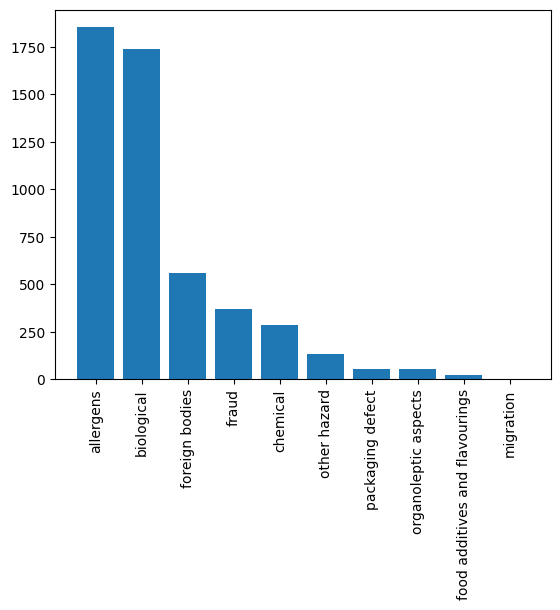

In [153]:
print_column(data, 'hazard-category')

- It is clear that the `hazard-category` column exhibits an `imbalance` in the distribution of its values.
    - For example, `allergens` has a frequence equal to `1854`, whereas `migration` has  a frequence equal to `3`.
- We will move on with the column `hazard`.

Column "hazard" (n = 128):

  listeria monocytogenes:                              665
  salmonella:                                          621
  milk and products thereof:                           588
  nuts:                                                240
  escherichia coli:                                    237
  cereals:                                             214
  peanuts and products thereof:                        211
  eggs and products thereof:                           208
  cereals containing gluten and products thereof:      207
  plastic fragment:                                    206
  other:                                               185
  soybeans and products thereof:                       170
  metal fragment:                                      155
  sulphur dioxide:                                     111
  inspection issues:                                   101
  sulphur dioxide and sulphites:                        93
  glass fragment:           

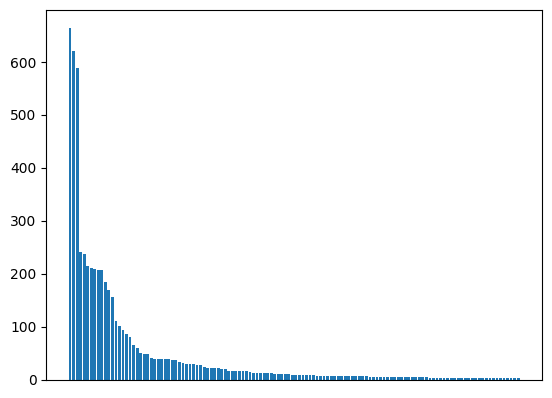

In [154]:
print_column(data, 'hazard',128)

- It is clear that the `hazard` column exhibits an `imbalance` in the distribution of its values.
    - The `hazard` column demonstrates `a long right skew`, indicating that `a small number of categories dominate the dataset`, while most other categories occur infrequently. This imbalance highlights the need for targeted data augmentation or resampling techniques to ensure the model adequately learns from underrepresented classes.
- We will move on with the column `product-category`.

Column "product-category" (n = 22):

  meat, egg and dairy products:                       1434
  cereals and bakery products:                         671
  fruits and vegetables:                               535
  prepared dishes and snacks:                          469
  seafood:                                             268
  soups, broths, sauces and condiments:                264
  nuts, nut products and seeds:                        262
  ices and desserts:                                   222
  cocoa and cocoa preparations, coffee and tea:        210
  alcoholic beverages:                                 193
  confectionery:                                       170
  non-alcoholic beverages:                             134
  dietetic foods, food supplements, fortified foods:   131
  herbs and spices:                                    125
  other food product / mixed:                           55
  pet feed:                                             20
  fats and oils:   

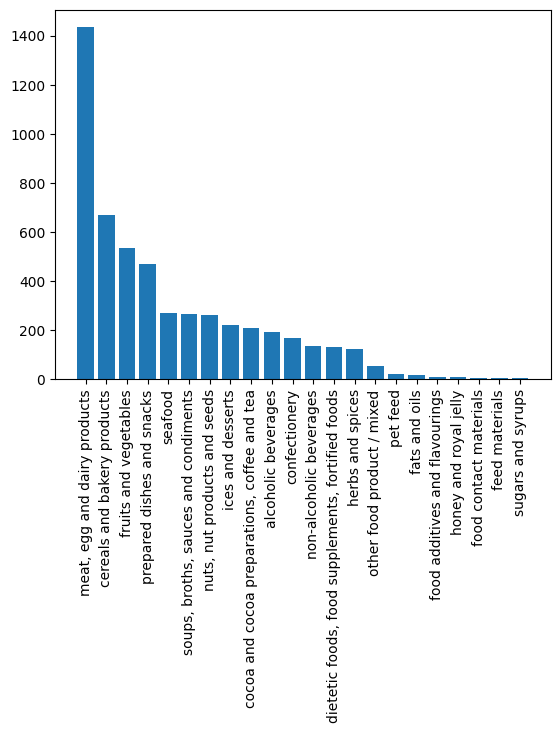

In [155]:
print_column(data, 'product-category',22)

- It is clear that the `product-category` column exhibits an `imbalance` in the distribution of its values.
    - For example, `meet,egg and dairy products` has a frequence equal to `1434`, whereas `sugars and syrups` has  a frequence equal to `5`.
- We will move on with the column `product`.

Column "product" (n = 1022):

  chicken:                                             309
  beef:                                                280
  cheese:                                              231
  chocolate:                                           206
  ice cream:                                           185
  nuts:                                                160
  chicken based products:                              138
  milk:                                                131
  sauce:                                               124
  cakes:                                               116
  sausage:                                             108
  beef meat:                                           107
  ready to eat - cook meals:                            79
  cookies:                                              78
  salads:                                               74
  pork meat:                                            72
  bars:                   

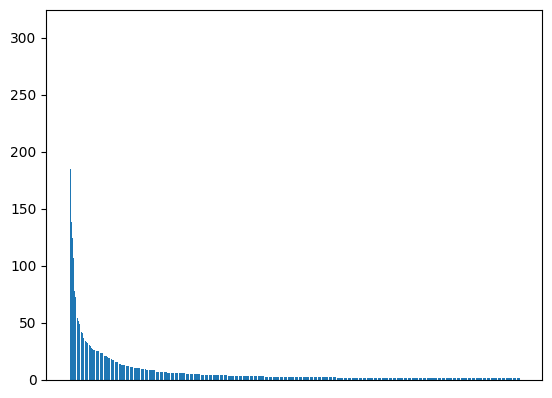

In [156]:
print_column(data, 'product',1022)

- It is clear that the `product` column exhibits an `imbalance` in the distribution of its values.
    - The product column demonstrates `a long right skew`, indicating that `a small number of categories dominate the dataset`, while most other categories occur infrequently. This imbalance highlights the need for targeted data augmentation or resampling techniques to ensure the model adequately learns from underrepresented classes.
- **So, all `y` columns are imbalanced**.

## Data Augmentation
- In this section, we will implement the necessary code to generate `synthetic data for the minority classes`, addressing the imbalance in the dataset. This process will help improve model performance by ensuring that all classes are adequately represented during training.
- Firslty we will need to download the following: 
    - **`nltk.download('punkt')`**: Downloads the Punkt tokenizer for sentence and word tokenization.
    - **`nltk.download('wordnet')`**: Downloads the WordNet lexical database for synonyms, antonyms, and word relationships.
    - **`nltk.download('stopwords')`**: Downloads a list of stop words (e.g., "the", "and") for text preprocessing.
    - **`stop_words = set(nltk.corpus.stopwords.words('english'))`**: Loads English stop words into a set for efficient filtering.
    - **`from nltk.corpus import wordnet`**: Imports WordNet for use in text processing.


In [157]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))
# try:
#     nltk.data.find('wordnet.zip')
# except:
#     nltk.download('wordnet', download_dir='/kaggle/working/')
#     command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
#     subprocess.run(command.split())
#     nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to /Users/evangelia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/evangelia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/evangelia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- We will create the function `get_synonyms` for generatig synonyms words.
    - It will be helpful for our aim being data augmentation 

In [158]:
def get_synonyms(word):
    """
    Retrieves a list of synonyms for a given word using the WordNet lexical database.

    :param word: str
        The word for which synonyms are to be fetched.
    
    :return: list
        A list of unique synonyms for the input word.
    
    :example:
        >>> get_synonyms("happy")
        ['felicitous', 'glad', 'happy', 'elated', 'joyful']
    """
    synonyms = set()  # Use a set to avoid duplicate synonyms.
    for syn in wordnet.synsets(word):  # Iterate over all synsets (meanings) of the word.
        for lemma in syn.lemmas():  # Access each lemma (word variant) of the synset.
            synonyms.add(lemma.name())  # Add the lemma name to the synonyms set.
    return list(synonyms)  # Convert the set to a list before returning.

- - **`augment_text`**: Generates augmented versions of input text by replacing words with synonyms and randomly adding or removing words, creating diverse variations of the original sentence.

In [159]:
def augment_text(text, num_augments=1):
    """
    Generates augmented versions of the input text by replacing words with their synonyms 
    and randomly adding or removing words.

    :param text: str
        The input text to be augmented.
    :param num_augments: int, optional (default=1)
        The number of augmented versions of the input text to generate.
    
    :return: list
        A list containing `num_augments` augmented versions of the input text.
    
    :example:
        >>> augment_text("The quick brown fox jumps", num_augments=2)
        ['The quick brown fox leaps', 'The swift brown fox']
    """
    augmented_texts = []
    words = word_tokenize(text)  # Tokenize the input text into words.
    
    for _ in range(num_augments):
        augmented_text = words.copy()
        
        # Replace words with synonyms
        for i, word in enumerate(words):
            synonyms = get_synonyms(word)  # Fetch synonyms for the word.
            if synonyms:
                augmented_text[i] = random.choice(synonyms)  # Randomly replace with a synonym.
        
        # Randomly add or remove a word
        if random.random() < 0.5: 
            augmented_text.append(random.choice(words))  # Add a random word from the original text.
        else:
            if len(augmented_text) > 1:
                augmented_text.remove(random.choice(augmented_text))  # Remove a random word.
        
        # Join the augmented words back into a single string and add to results
        augmented_texts.append(' '.join(augmented_text))
    
    return augmented_texts

- **`balance_dataframe`**: Balances a DataFrame by generating augmented samples for underrepresented classes in the target column, using a specified augmentation ratio. This ensures more equitable representation of all classes for training. 


In [160]:
def balance_dataframe(df, target_column, ratio=0.2):
    """
    Balances a DataFrame by augmenting data for underrepresented classes in the target column.

    :param df: pd.DataFrame
        The input DataFrame to be balanced. It must include the target column 
        and other necessary columns (e.g., 'title', 'text') for augmentation.
    :param target_column: str
        The name of the column containing the target labels/classes to balance.
    :param ratio: float, optional (default=0.2)
        The ratio of augmentation to perform for underrepresented classes compared 
        to the most represented class. Determines how many synthetic samples are generated.
    
    :return: pd.DataFrame
        The balanced DataFrame with augmented rows added for underrepresented classes.
    
    :example:
        >>> balanced_df = balance_dataframe(df, target_column='category', ratio=0.3)
    """
    max_count = df[target_column].value_counts().max() #maybe could change, im checking anything that is below the max, maybe we should do it below max/3 or something
    
    for label in df[target_column].unique():
        label_df = df[df[target_column] == label]
        count_label = len(label_df)
        
        if count_label < max_count:
            samples_to_generate = int((max_count // count_label) * ratio)
            
            augmented_data = []
            
            for i in range(samples_to_generate):
                row = label_df.sample(1).iloc[0]
                
                augmented_title = augment_text(row['title'])[0] 
                augmented_text = augment_text(row['text'])[0]    
                
                new_row = row.copy()
                new_row['title'] = augmented_title
                new_row['text'] = augmented_text     
                
                augmented_data.append(new_row)
            
            
            augmented_df = pd.DataFrame(augmented_data)
            df = pd.concat([df, augmented_df], ignore_index=True)
    
    return df

- Firstly, we call the function `balance_dataframe` for the column `hazard`.
    - Note: many `y` (that is `hazard`, `hazard-category`, `product`, `product-category`) columns share common `x` (taht is `text` and `title`) inputs.

In [161]:
balanced = balance_dataframe(data,"hazard")

In [162]:
balanced

,year,month,day,country,title,text,hazard-category,product-category,hazard,product
0,1994,1,7,us,Recall Notification: FSIS-024-94,Case Number: 024-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,1994,3,10,us,Recall Notification: FSIS-033-94,Case Number: 033-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria spp,sausage
2,1994,3,28,us,Recall Notification: FSIS-014-94,Case Number: 014-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices
3,1994,4,3,us,Recall Notification: FSIS-009-94,Case Number: 009-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,thermal processed pork meat
4,1994,7,1,us,Recall Notification: FSIS-001-94,Case Number: 001-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,chicken breast
...,...,...,...,...,...,...,...,...,...,...
7572,2021,12,23,ie,reminiscence of amp mint of ball-shaped Botani...,callback of deoxyadenosine_monophosphate pile ...,chemical,other food product / mixed,too high content of tetrahydrocannabinol (THC),cbd products
7573,2021,8,26,ie,retrieve of Vita d ’ Beaver_State Bio constitu...,retrieve of Vita ergocalciferol ’ Oregon Bio o...,chemical,"cocoa and cocoa preparations, coffee and tea",too high content of tetrahydrocannabinol (THC),hemp tea
7574,2021,12,23,ie,return of Kama hangman's_rope CBD participatin...,call_in of Kama hempen_necktie CBD combat-read...,chemical,other food product / mixed,too high content of tetrahydrocannabinol (THC),cbd products
7575,2021,8,26,ie,call_in of Vita D ’ OR constituent hempen_neck...,call_in of Vita cholecalciferol ’ Beaver_State...,chemical,"cocoa and cocoa preparations, coffee and tea",too high content of tetrahydrocannabinol (THC),hemp tea


- We can observe that the total number of rows increased. 
    - Now, being equal to `7577` (the initial rows were equal to 5082).
- **`plot_balanced`**: Creates side-by-side bar plots to compare the distribution of a categorical column in the original and balanced DataFrames, highlighting the effects of data balancing. 
- **General Note**: We decided to "hold" the imbalance of classes for example we added extra data for the  high supported classes, too. TODO 

In [163]:
def plot_balanced(old_df, new_df, column_name):
    """
    Plots a side-by-side comparison of the distribution of a categorical column
    before and after balancing.

    :param old_df: pd.DataFrame
        The original DataFrame before balancing.
    :param new_df: pd.DataFrame
        The balanced DataFrame after augmentation.
    :param column_name: str
        The name of the column (categorical) to visualize and compare distributions.
    
    :return: None
        Displays the plots showing the count distributions of the specified column
        for the original and balanced DataFrames.
    
    :example:
        >>> plot_balanced(old_df, new_df, column_name="category")
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Original DataFrame
    sns.countplot(data=old_df, x=column_name, ax=axes[0], hue=column_name, palette="Set2", legend=False)
    axes[0].set_title(f"Original {column_name} Distribution")
    axes[0].set_xlabel(column_name)
    axes[0].set_ylabel("Count")
    axes[0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-axis labels

    # Balanced DataFrame
    sns.countplot(data=new_df, x=column_name, ax=axes[1], hue=column_name, palette="Set2", legend=False)
    axes[1].set_title(f"Balanced {column_name} Distribution")
    axes[1].set_xlabel(column_name)
    axes[1].set_ylabel("Count")
    axes[1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-axis labels

    
    plt.tight_layout()  
    plt.show()

- Let's call the function `plot_balanced` for each of our `y` labels.

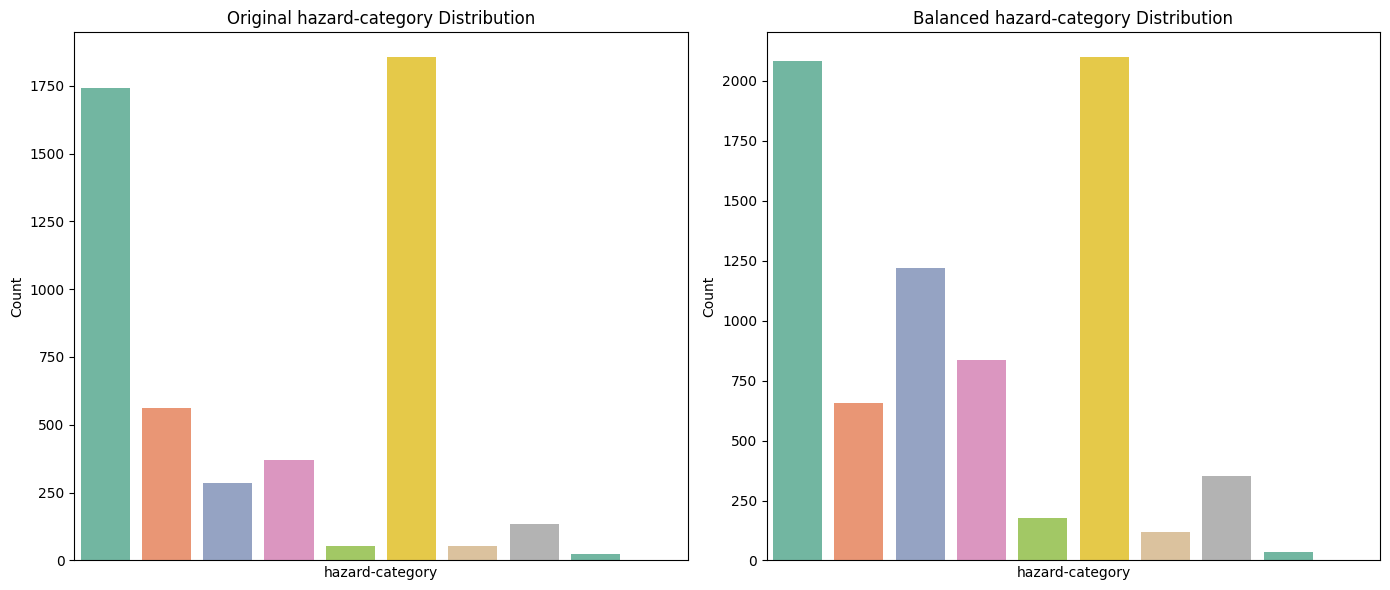

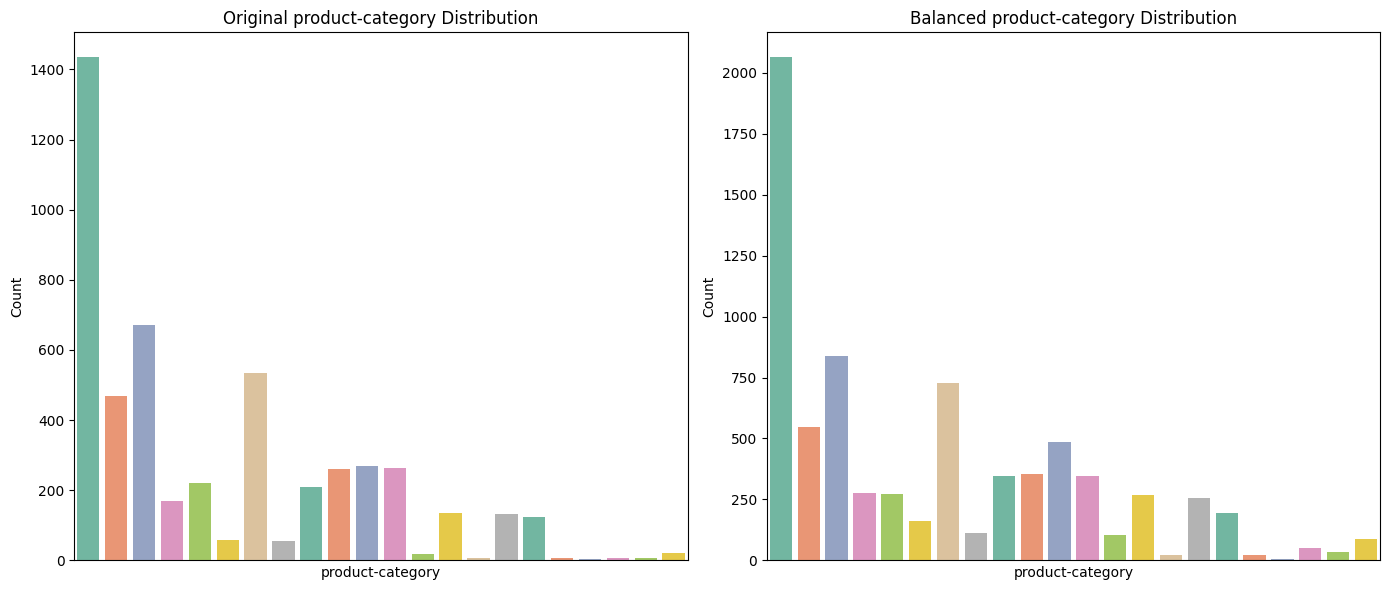

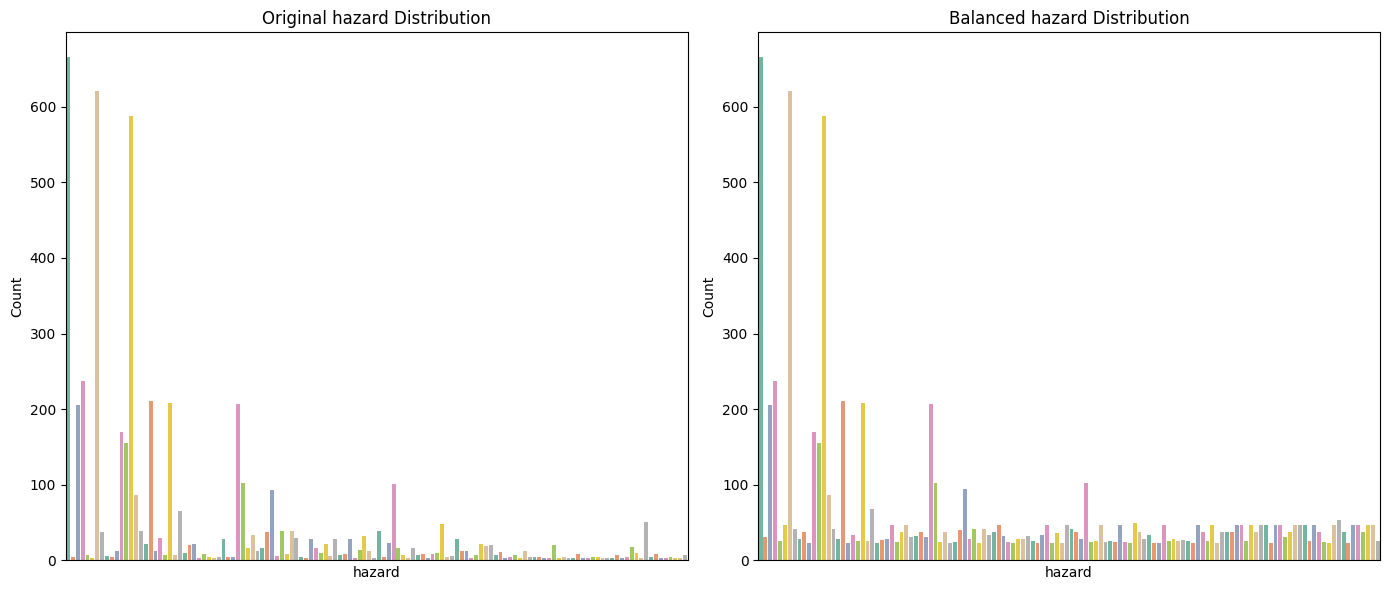

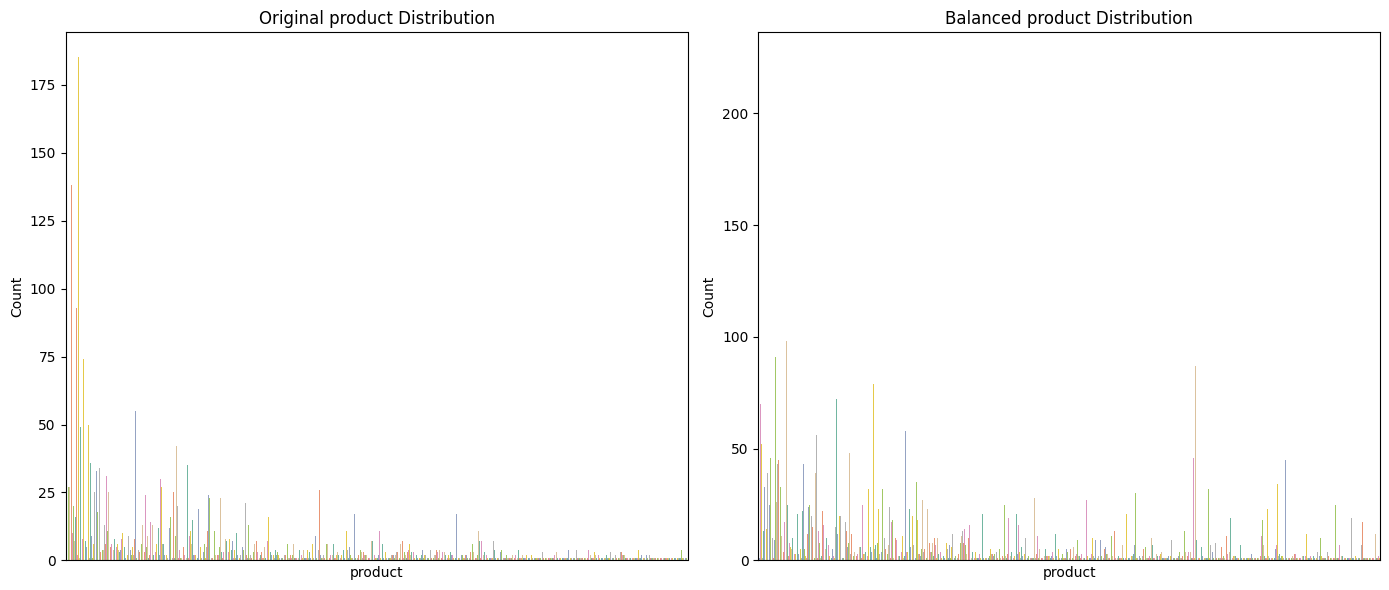

In [164]:
plot_balanced(data, balanced, 'hazard-category')
plot_balanced(data, balanced, 'product-category')
plot_balanced(data, balanced, 'hazard')
plot_balanced(data, balanced, 'product')

- Observing the plot above, we can observe that some valeus in classes (in the right) has been increased.
- We call the function `balance_dtafarme` for the column `hazard-category` and we replot via the function `plot_balance`.
    - This process buld on the already modified dataset that is `balanced` (first call).

In [165]:
balanced_2 = balance_dataframe(balanced,"hazard-category")

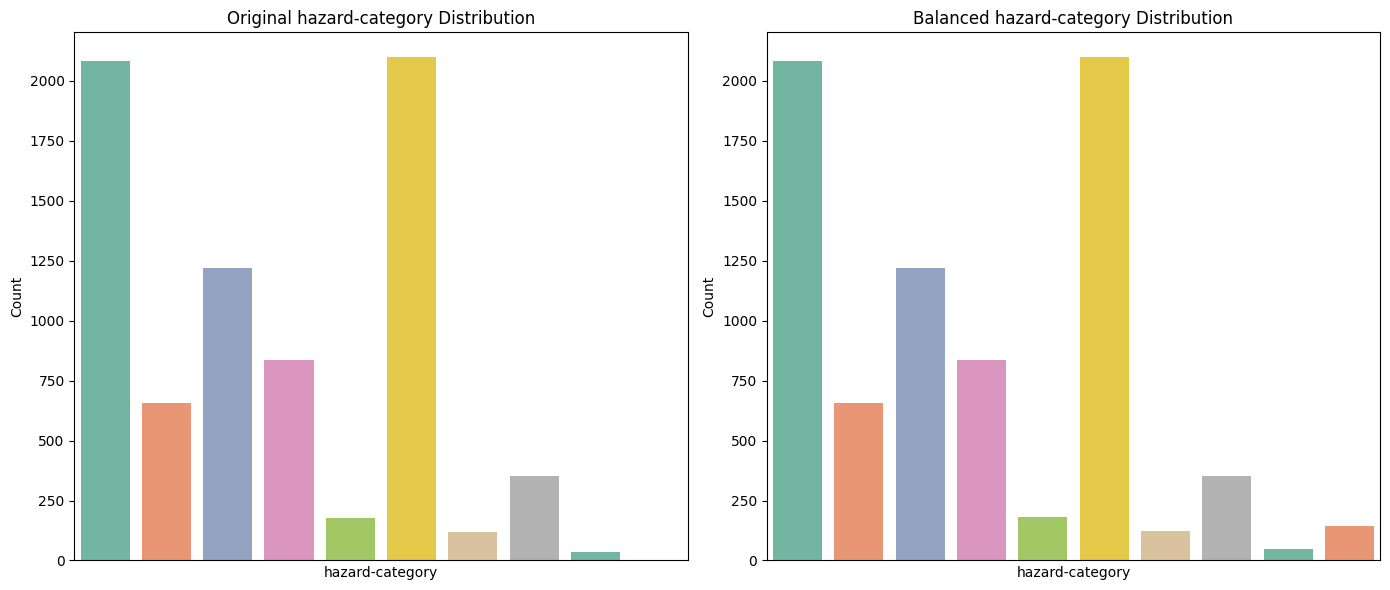

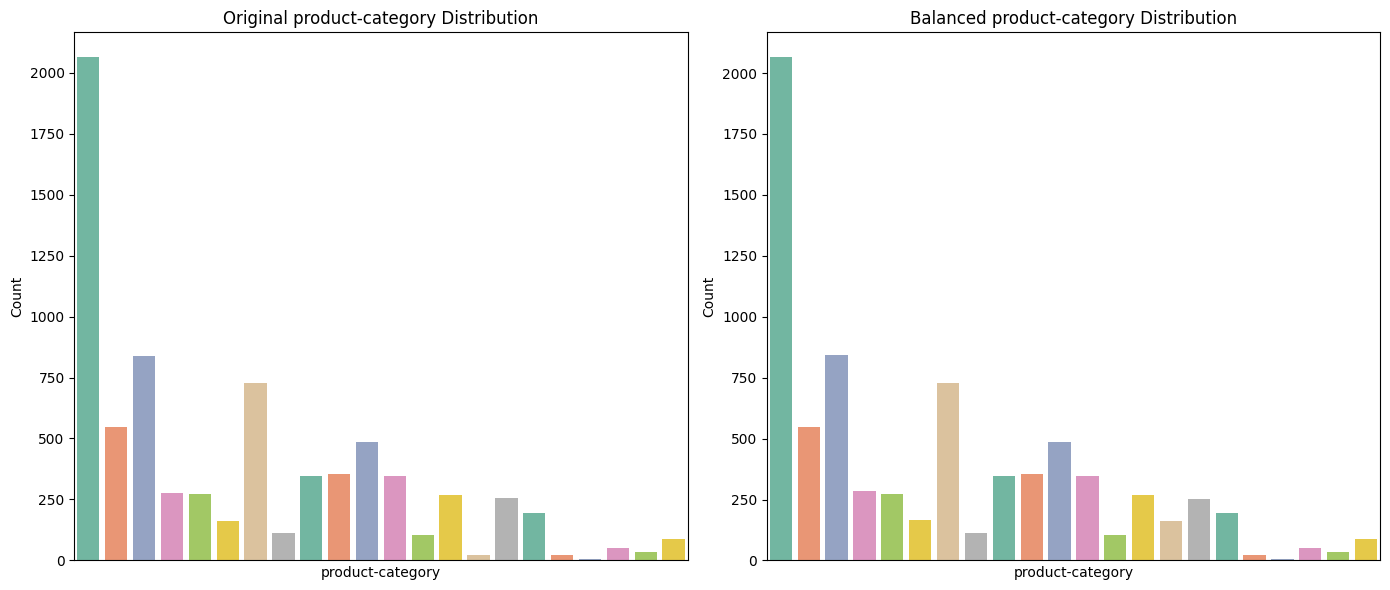

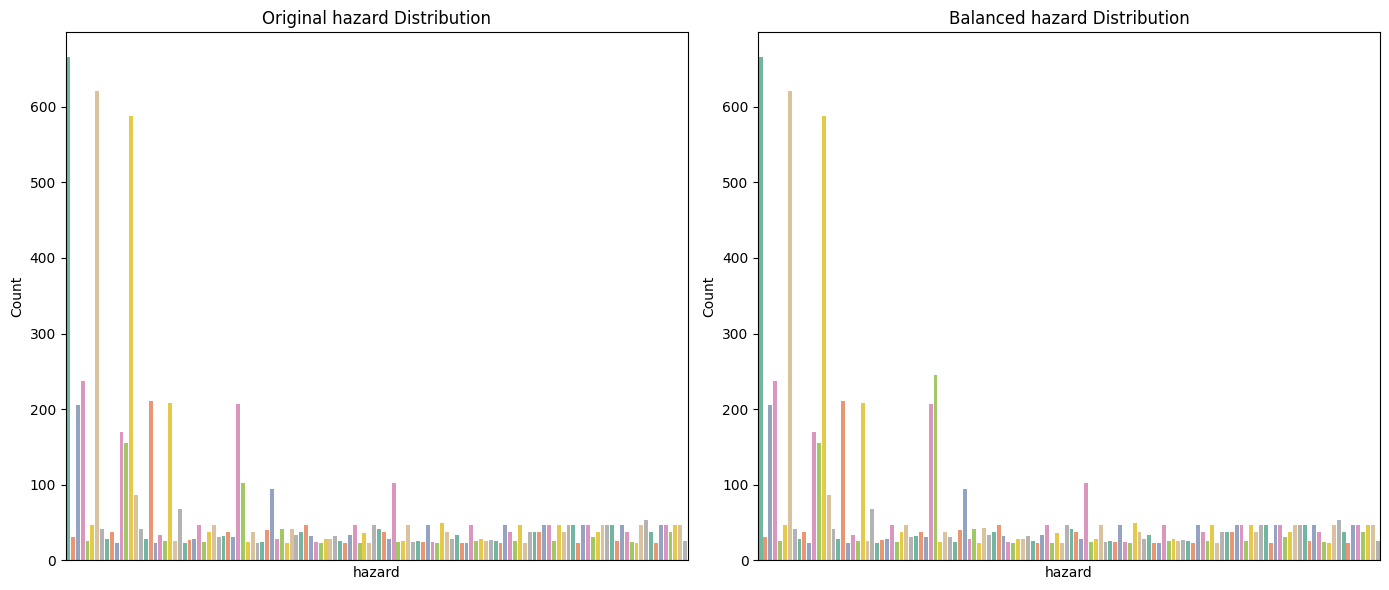

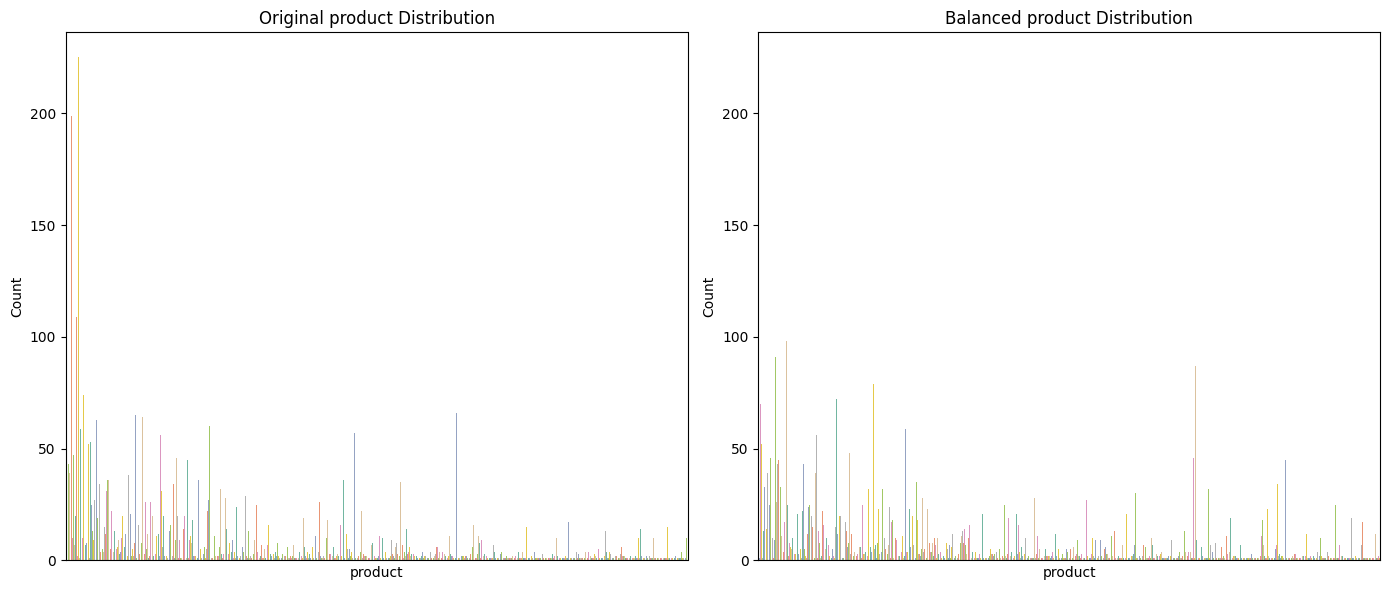

In [166]:
plot_balanced(balanced, balanced_2, 'hazard-category')
plot_balanced(balanced, balanced_2, 'product-category')
plot_balanced(balanced, balanced_2, 'hazard')
plot_balanced(balanced, balanced_2,'product')

- Running the process in the second time, and obserning the diagrams above, it is obvious that the data are more balance as the number of minor classes have been increased.
- We will move on via re-calling the function `balance_dataframe` for the column `product-category`.
- Then we will re-plot the new "balanced" using the function `plot_balance`. 

In [167]:
balanced_3 = balance_dataframe(balanced_2,"product-category")

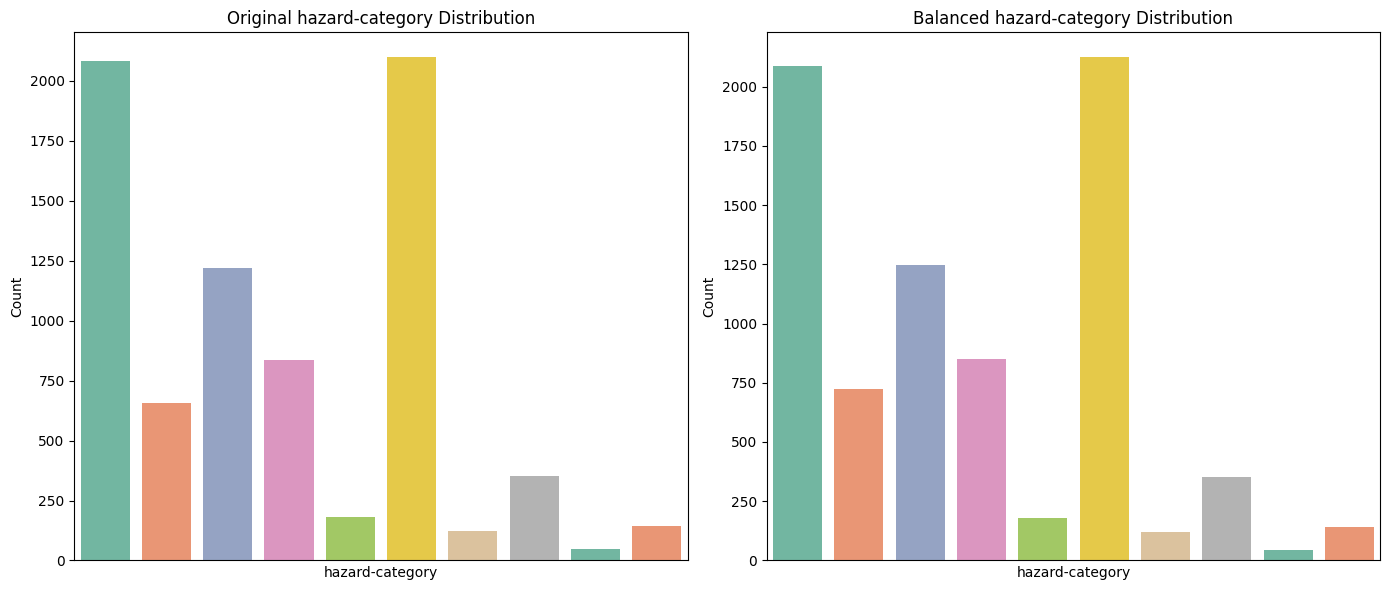

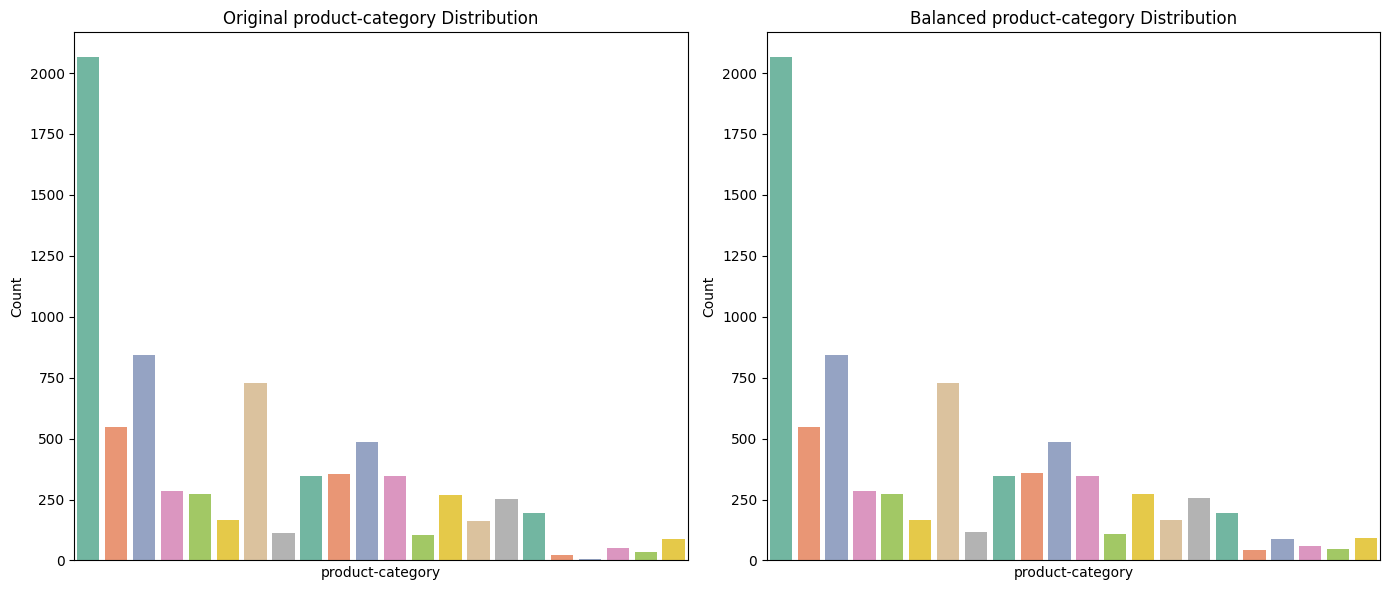

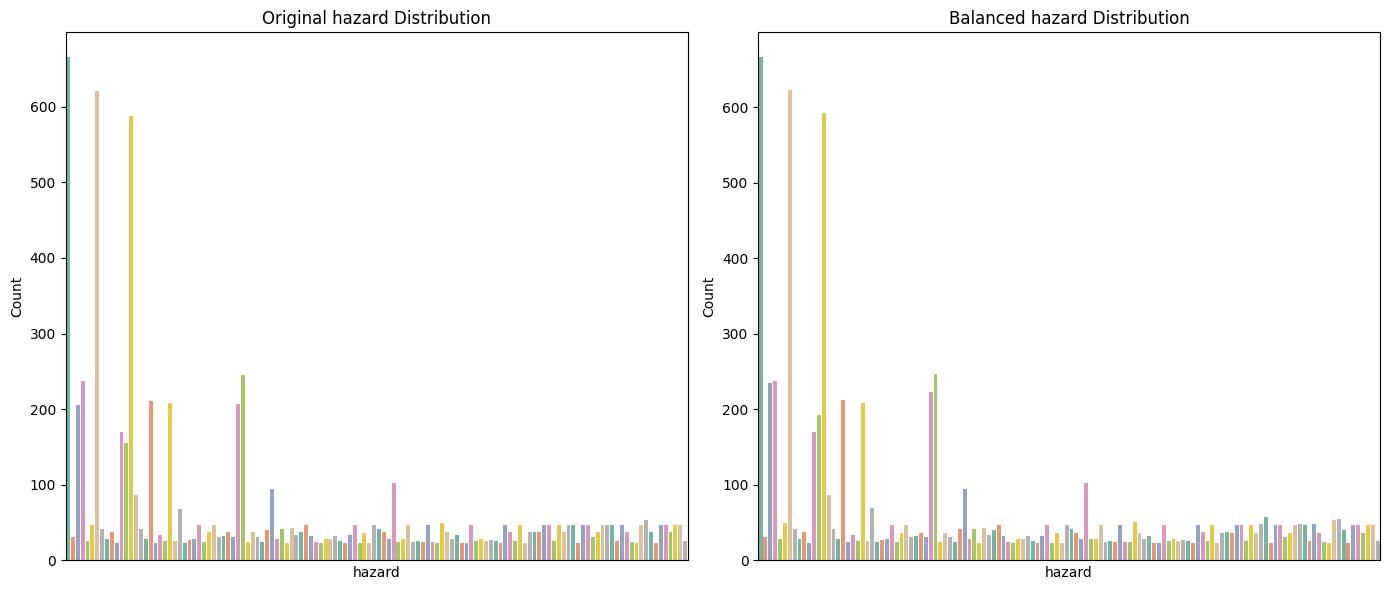

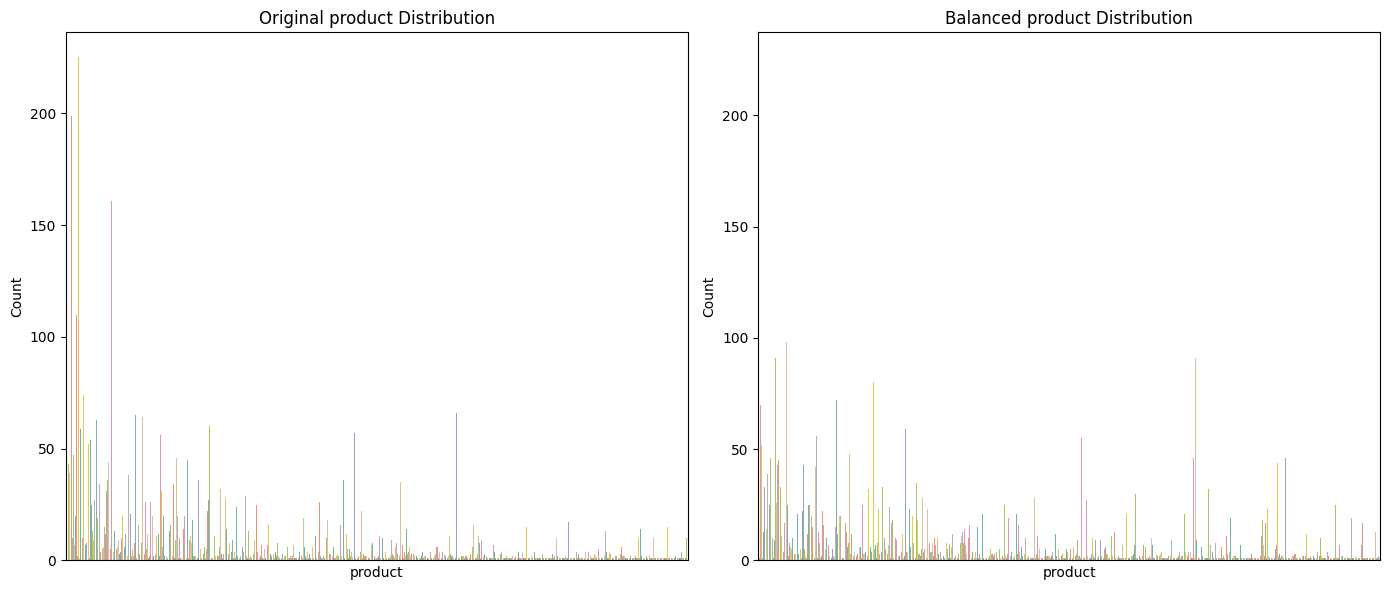

In [168]:
plot_balanced(balanced_2, balanced_3, 'hazard-category')
plot_balanced(balanced_2, balanced_3, 'product-category')
plot_balanced(balanced_2, balanced_3, 'hazard')
plot_balanced(balanced_2, balanced_3,'product')

- Again obserining the plots, in some values if classes then number of instances has been increased. 
- We will re-run a last time, but now for the column `produt`.

In [169]:
balanced_4 = balance_dataframe(balanced_3,"product",ratio=0.05)

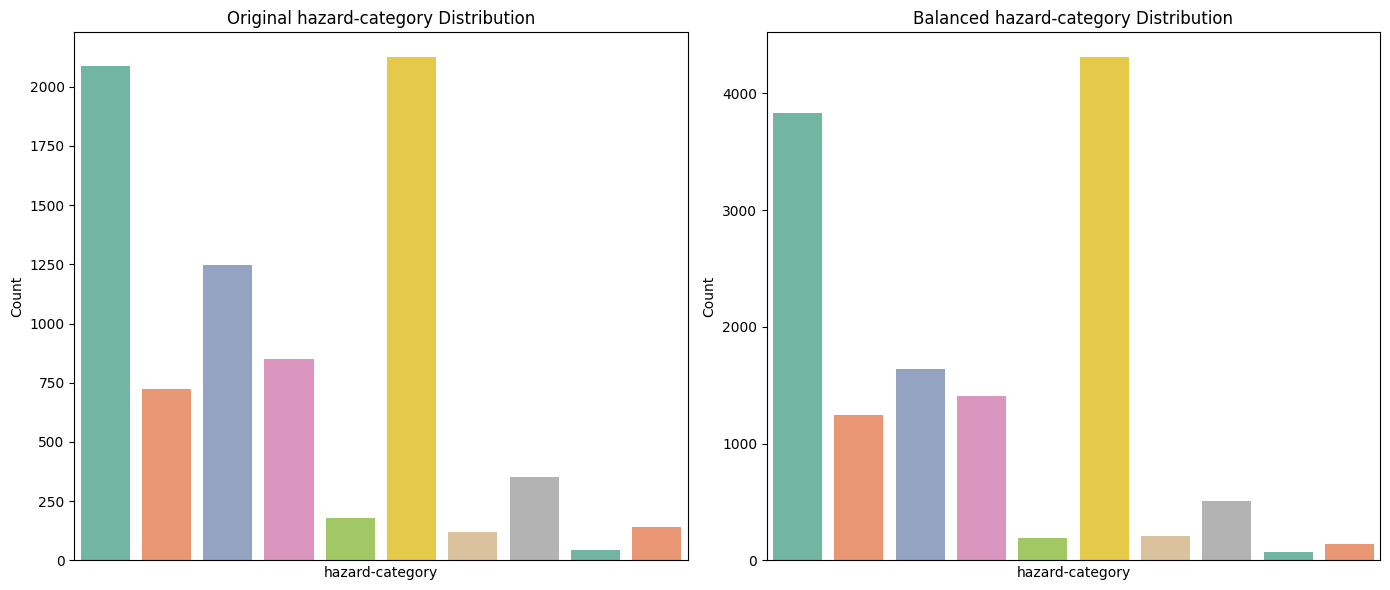

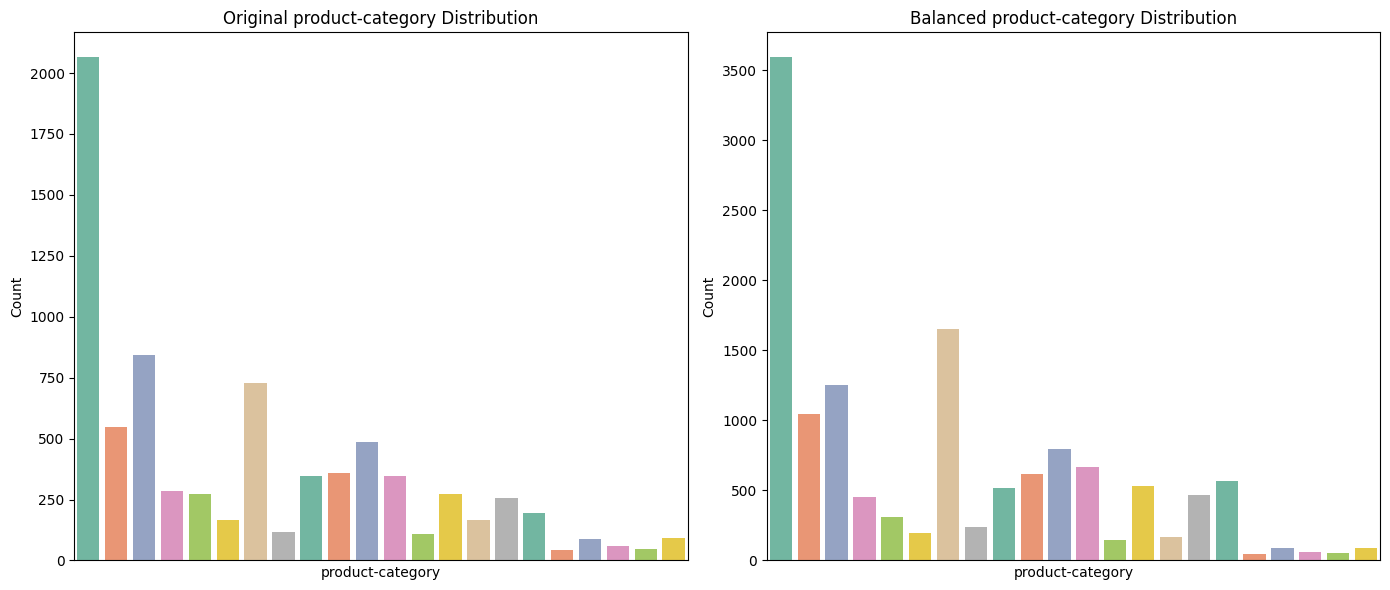

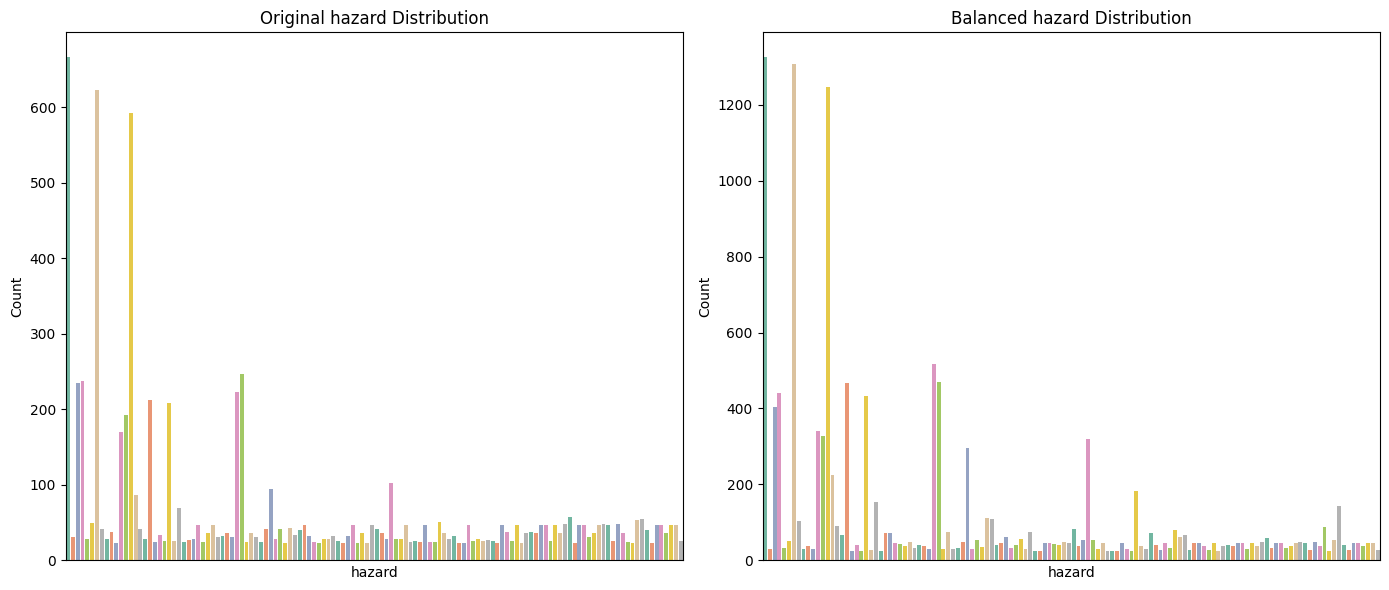

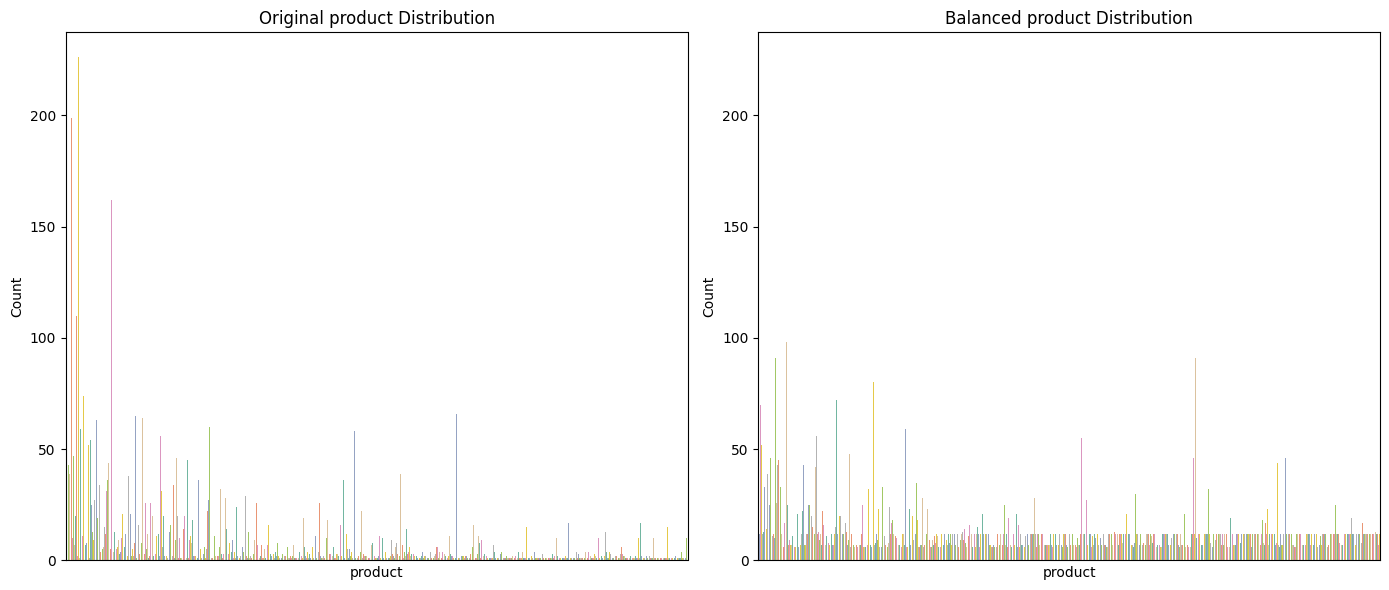

In [170]:
plot_balanced(balanced_3, balanced_4, 'hazard-category')
plot_balanced(balanced_3, balanced_4, 'product-category')
plot_balanced(balanced_3, balanced_4, 'hazard')
plot_balanced(balanced_3, balanced_4,'product')

- The intresting effect of this run is for the `product` column as the majority of values has been increased compared to the original one. 

In [171]:
balanced_4

,year,month,day,country,title,text,hazard-category,product-category,hazard,product
0,1994,1,7,us,Recall Notification: FSIS-024-94,Case Number: 024-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,1994,3,10,us,Recall Notification: FSIS-033-94,Case Number: 033-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria spp,sausage
2,1994,3,28,us,Recall Notification: FSIS-014-94,Case Number: 014-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices
3,1994,4,3,us,Recall Notification: FSIS-009-94,Case Number: 009-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,thermal processed pork meat
4,1994,7,1,us,Recall Notification: FSIS-001-94,Case Number: 001-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,chicken breast
...,...,...,...,...,...,...,...,...,...,...
13545,2022,7,19,hk,fibrocystic_disease_of_the_pancreas urge_on pu...,CF exhort populace not to devour sort of cup a...,chemical,other food product / mixed,unauthorised substance ethylene oxide,ramen noodles
13546,2022,7,19,hk,pancreatic_fibrosis cheer public not to go_thr...,Cf inspire populace not to deplete sort of cup...,chemical,other food product / mixed,unauthorised substance ethylene oxide,ramen noodles
13547,2022,7,19,hk,CF advocate public to go_through sort of cup b...,Cf inspire public not to go_through variety of...,chemical,other food product / mixed,unauthorised substance ethylene oxide,ramen noodles
13548,2022,7,19,hk,CF barrack world non to waste genial of cup no...,mucoviscidosis impulse populace not to exhaust...,chemical,other food product / mixed,unauthorised substance ethylene oxide,ramen noodles


### Compare Original Distribution of `y` with the Augmented Data

In [172]:
print("Shape of the Initial Data Frame: ",data[['hazard-category', 'product-category', 'hazard', 'product']].shape[0]) # shape of **initial** dataframe
print("Shape of the Transformed-Balanced Data Frame: ",balanced_4[['hazard-category', 'product-category', 'hazard', 'product']].shape[0]) # shape of **balanced-trasformed** dataframe

Shape of the Initial Data Frame:  5082
Shape of the Transformed-Balanced Data Frame:  13550


In [173]:
abs(data[['hazard-category', 'product-category', 'hazard', 'product']].shape[0] - balanced_4[['hazard-category', 'product-category', 'hazard', 'product']].shape[0])

8468

- Following the application of data augmentation, the dataset expanded by an `additional 8,527 rows`.
- **`compare_augmentation_effects`**: Analyzes and visualizes the impact of data augmentation by comparing unique value counts for specified columns in the original and augmented datasets. It generates side-by-side bar plots with counts above the bars, allowing for a clear comparison of top or bottom values.
    - **`show_top`**: A boolean argument that determines which rows to display in the comparison:
        - **`True`** (default): Displays the top 10 rows with the highest counts.
        - **`False`**: Displays the bottom 10 rows with the lowest counts.
    - This arguments is crucial for columns (like `hazard`, `product` having many-many values). 


In [174]:
def compare_augmentation_effects(original_df, augmented_df, columns, show_top=True):
    """
    Compares the increase in unique value counts for specified columns 
    between the original and augmented datasets using side-by-side bar plots.

    :param original_df: pd.DataFrame
        The original DataFrame before augmentation.
    :param augmented_df: pd.DataFrame
        The augmented DataFrame after augmentation.
    :param columns: list
        List of column names to analyze.
    :param show_top: bool, optional (default=True)
        If True, shows the top 10 rows with the highest counts.
        If False, shows the bottom 10 rows with the lowest counts.
    :return: None
        Displays comparison tables and side-by-side bar plots with counts above bars for each column.
    """

    def plot_comparison(comparison, column, title_suffix):
        """
        Helper function to plot a bar chart for the given comparison DataFrame.

        :param comparison: pd.DataFrame
            The DataFrame containing the counts to plot.
        :param column: str
            The name of the column being analyzed.
        :param title_suffix: str
            A suffix to include in the plot title for clarification.
        """
        ax = comparison.plot(
            kind="bar",
            figsize=(12, 6),
            color=["skyblue", "salmon"],
            edgecolor="black"
        )
        plt.title(f"Comparison of '{column}' {title_suffix}", fontsize=14)
        plt.xlabel(column, fontsize=12)
        plt.ylabel("Counts", fontsize=12)
        plt.xticks(rotation=45, fontsize=10)
        plt.legend(title="Dataset", labels=["Original", "Augmented"], fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Add numbers above bars
        for p in ax.patches:
            ax.annotate(
                f"{p.get_height():,}",  # Add formatted number
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center",
                va="bottom",
                fontsize=10,
                color="black"
            )
        plt.tight_layout()
        plt.show()

    for column in columns:
        print(f"\n### Column: {column} ###")

        # Calculate value counts
        original_counts = original_df[column].value_counts()
        augmented_counts = augmented_df[column].value_counts()

        # Merge counts into a comparison DataFrame
        comparison = pd.DataFrame({
            "Original": original_counts,
            "Augmented": augmented_counts
        }).fillna(0).astype(int)  # Ensure missing values are filled and converted to integers

        # Sort the DataFrame
        comparison = comparison.sort_values(by="Augmented", ascending=False)

        # Select rows to display (top 10 or bottom 10)
        rows_to_display = comparison.head(10) if show_top else comparison.tail(10)

        # Print comparison table
        print(rows_to_display)

        # Plot the comparison
        plot_comparison(rows_to_display, column, "Before and After Augmentation (Top 10)" if show_top else "Before and After Augmentation (Bottom 10)")

### Compare Effect of Data Augmentation for 10 Low Classes for the DataFrame `balanced_4`

- In the following tables and plots, we can see for each `y` the effect of data augmentation (syntheti data) for the values belonging to low classes (low supported classes).
    - We will observe an `increase stemming from the data augmentation`.


### Column: hazard-category ###
                                Original  Augmented
hazard-category                                    
allergens                           1854       4306
biological                          1741       3833
chemical                             287       1635
fraud                                371       1407
foreign bodies                       561       1244
other hazard                         134        511
packaging defect                      54        208
organoleptic aspects                  53        190
migration                              3        143
food additives and flavourings        24         73


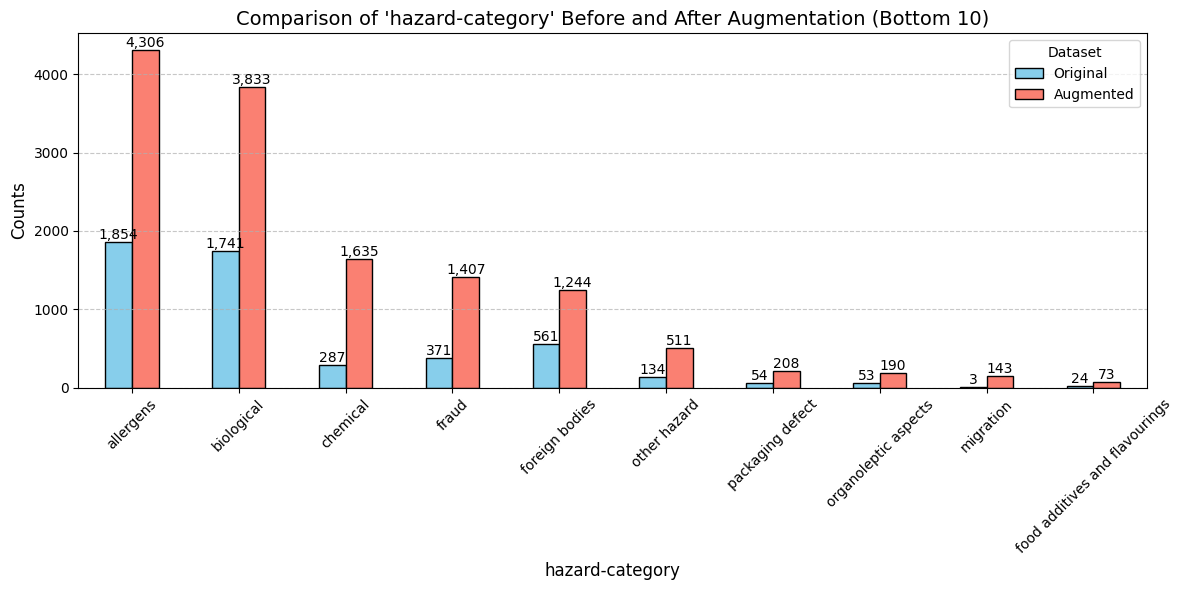


### Column: product-category ###
                                Original  Augmented
product-category                                   
ices and desserts                    222        309
other food product / mixed            55        238
alcoholic beverages                   59        196
food contact materials                 7        169
fats and oils                         19        147
pet feed                              20         91
sugars and syrups                      5         87
honey and royal jelly                  8         63
feed materials                         6         51
food additives and flavourings         8         46


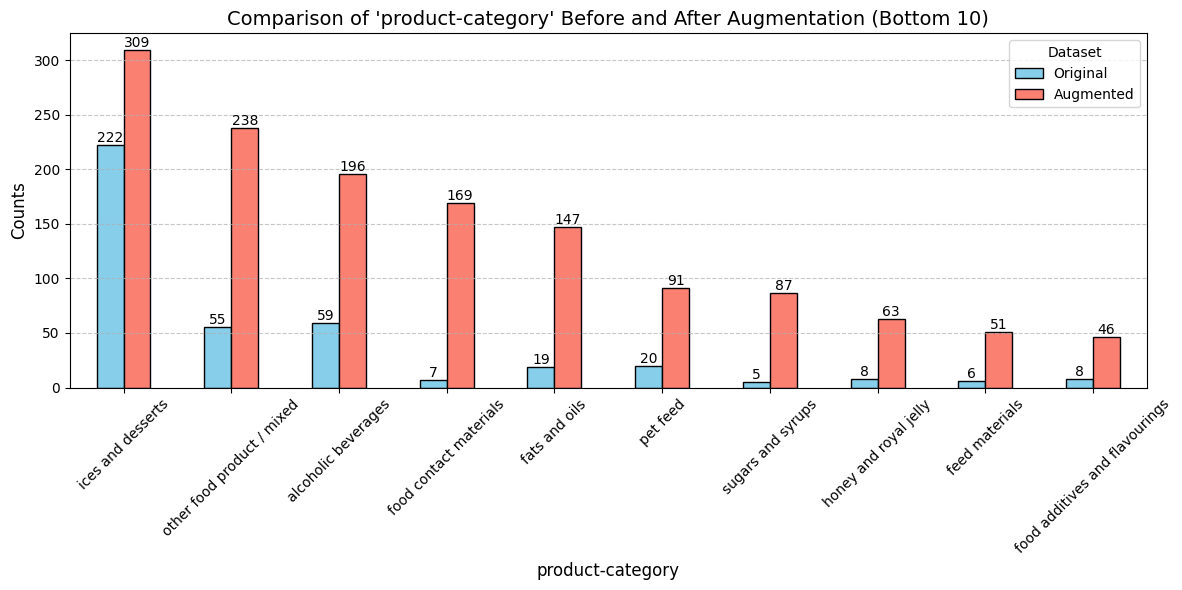


### Column: hazard ###
                                                 Original  Augmented
hazard                                                              
bone fragment                                          12         26
hazelnut                                               16         26
stones                                                  7         26
specified risk material (srm)                           9         26
pathogenic bacteria                                     7         26
cyclospora                                             10         25
other not classified biological hazards                13         25
Aflatoxin                                              10         25
other not classified hazards for foreign bodies         8         24
patulin                                                10         24


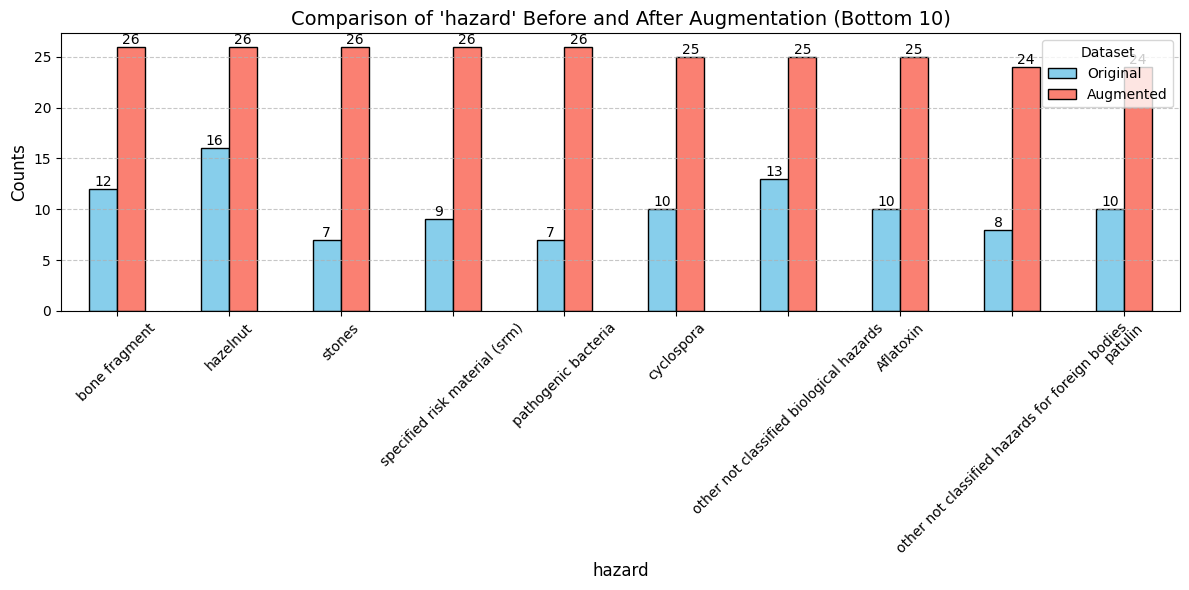


### Column: product ###
                    Original  Augmented
product                                
liquid egg white           3          6
coconut milk drink         4          6
stuffed pastry             3          6
salt                       3          6
cod                        3          6
blackberries               2          6
salami sticks              3          6
black pepper               3          6
sushi                      2          6
protein balls              4          6


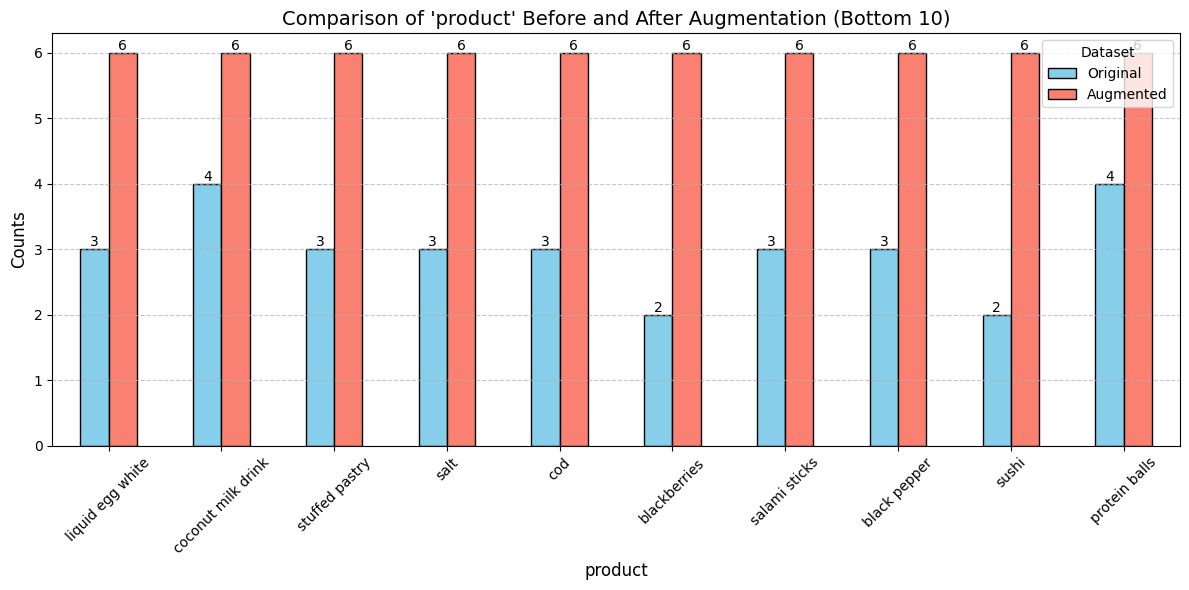

In [175]:
columns_to_compare = ['hazard-category', 'product-category', 'hazard', 'product']
compare_augmentation_effects(data, balanced_4, columns_to_compare, show_top=False)

### Compare Effect of Data Augmentation for 10 High Classes for the DataFrame `balanced_4`
- In the following tables and plots, we can see for each `y` the effect of data augmentation (syntheti data) for the values belonging to high classes (high supported classes).
    - We will observe an `increase stemming from the data augmentation`.


### Column: hazard-category ###
                                Original  Augmented
hazard-category                                    
allergens                           1854       4306
biological                          1741       3833
chemical                             287       1635
fraud                                371       1407
foreign bodies                       561       1244
other hazard                         134        511
packaging defect                      54        208
organoleptic aspects                  53        190
migration                              3        143
food additives and flavourings        24         73


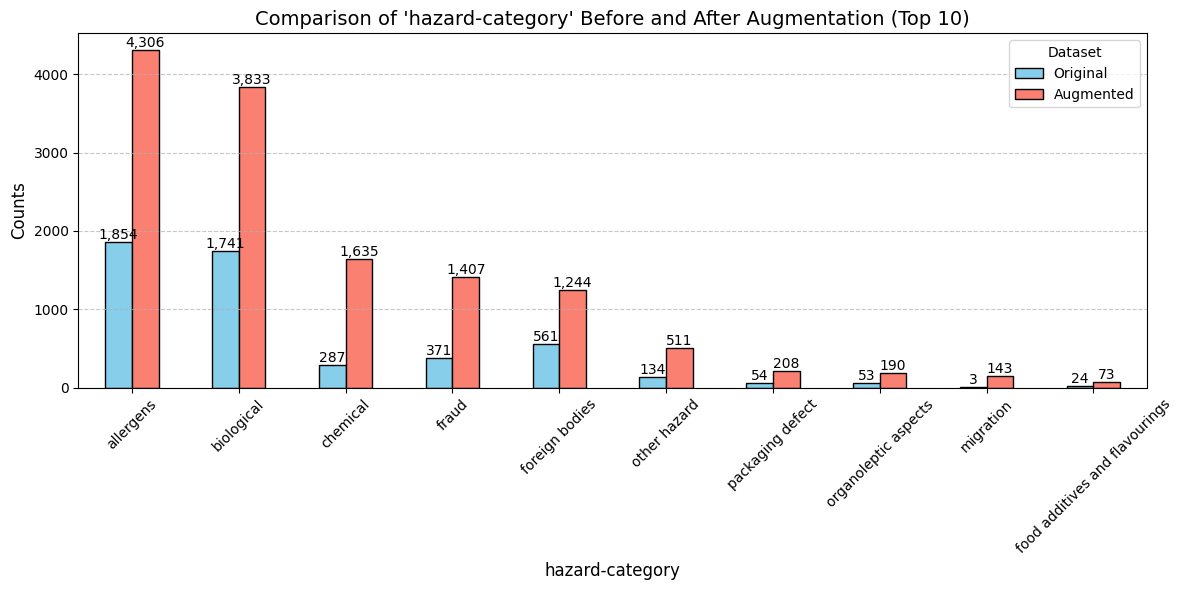


### Column: product-category ###
                                              Original  Augmented
product-category                                                 
meat, egg and dairy products                      1434       3591
fruits and vegetables                              535       1656
cereals and bakery products                        671       1253
prepared dishes and snacks                         469       1043
seafood                                            268        794
soups, broths, sauces and condiments               264        667
nuts, nut products and seeds                       262        620
herbs and spices                                   125        565
non-alcoholic beverages                            134        531
cocoa and cocoa preparations, coffee and tea       210        519


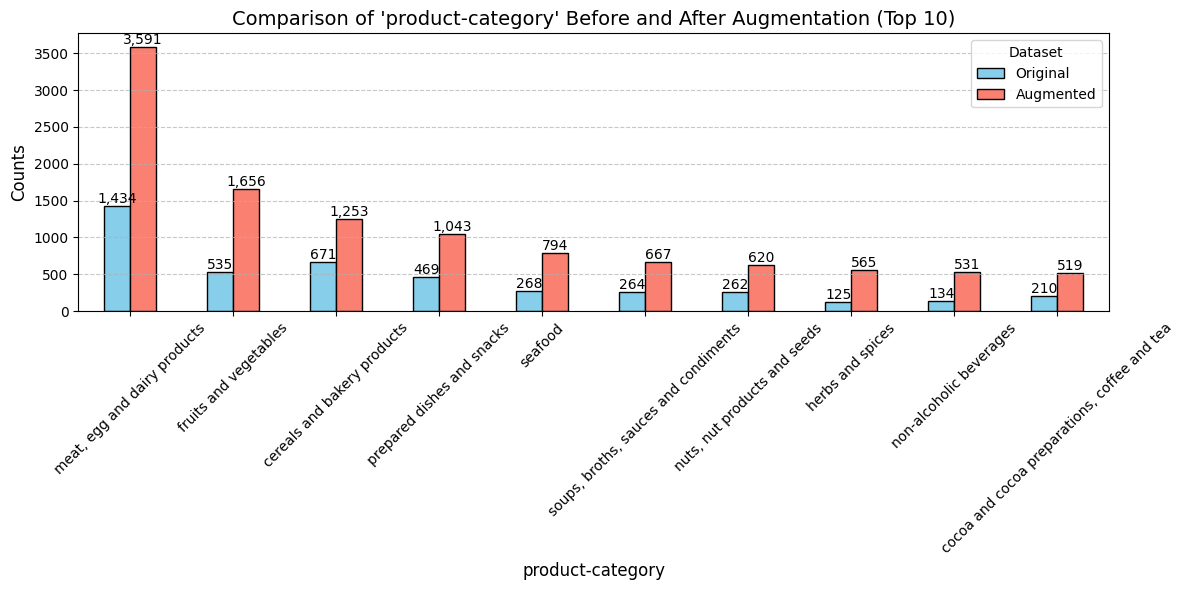


### Column: hazard ###
                                                Original  Augmented
hazard                                                             
listeria monocytogenes                               665       1324
salmonella                                           621       1306
milk and products thereof                            588       1247
cereals containing gluten and products thereof       207        516
other                                                102        471
peanuts and products thereof                         211        466
escherichia coli                                     237        442
eggs and products thereof                            208        432
plastic fragment                                     206        403
soybeans and products thereof                        170        340


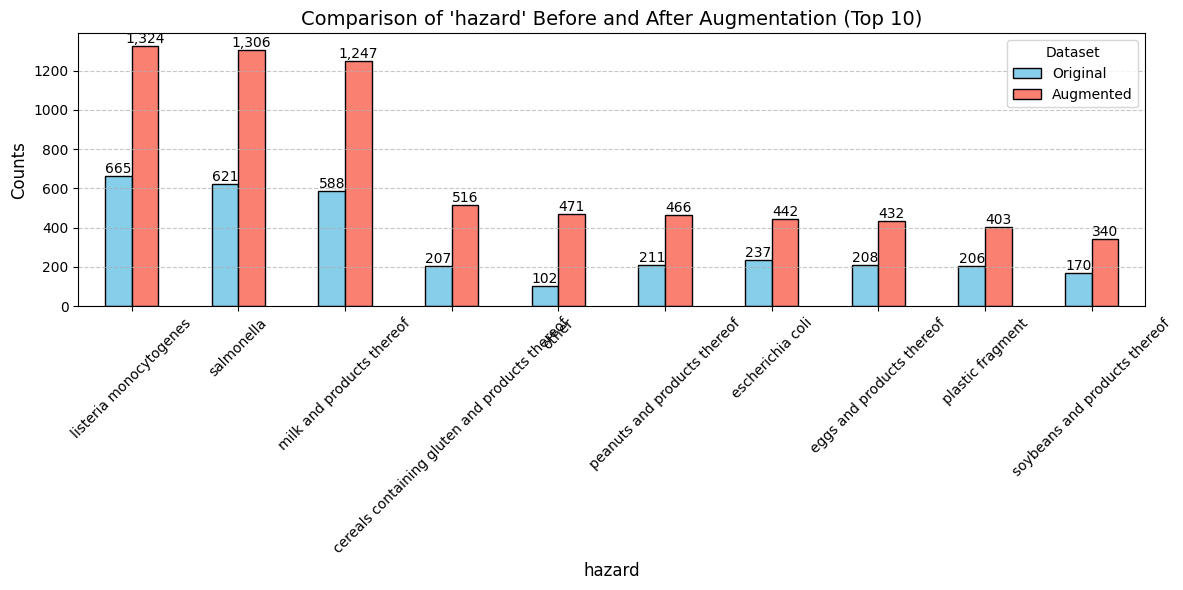


### Column: product ###
                           Original  Augmented
product                                       
ice cream                       185        226
chicken based products          138        199
plastics                          6        162
cakes                            93        110
ready to eat - cook meals        79         98
cookies                          78         91
pet feed                         20         91
beer                             25         80
cheese                           74         74
eggs                             26         72


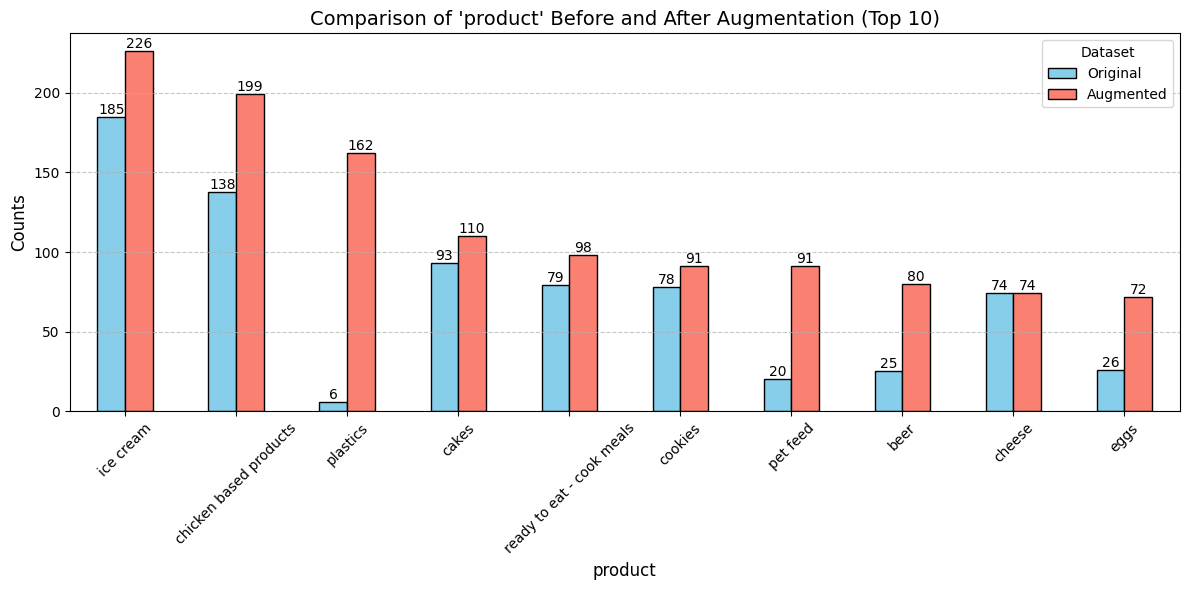

In [176]:
columns_to_compare = ['hazard-category', 'product-category', 'hazard', 'product']
compare_augmentation_effects(data, balanced_4, columns_to_compare, show_top=True)

### Compare Effect of Data Augmentation for 10 Low Classes for the DataFrame `balanced_3`


### Column: hazard-category ###
                                Original  Augmented
hazard-category                                    
allergens                           1854       2123
biological                          1741       2087
chemical                             287       1247
fraud                                371        852
foreign bodies                       561        722
other hazard                         134        352
organoleptic aspects                  53        181
migration                              3        143
packaging defect                      54        121
food additives and flavourings        24         46


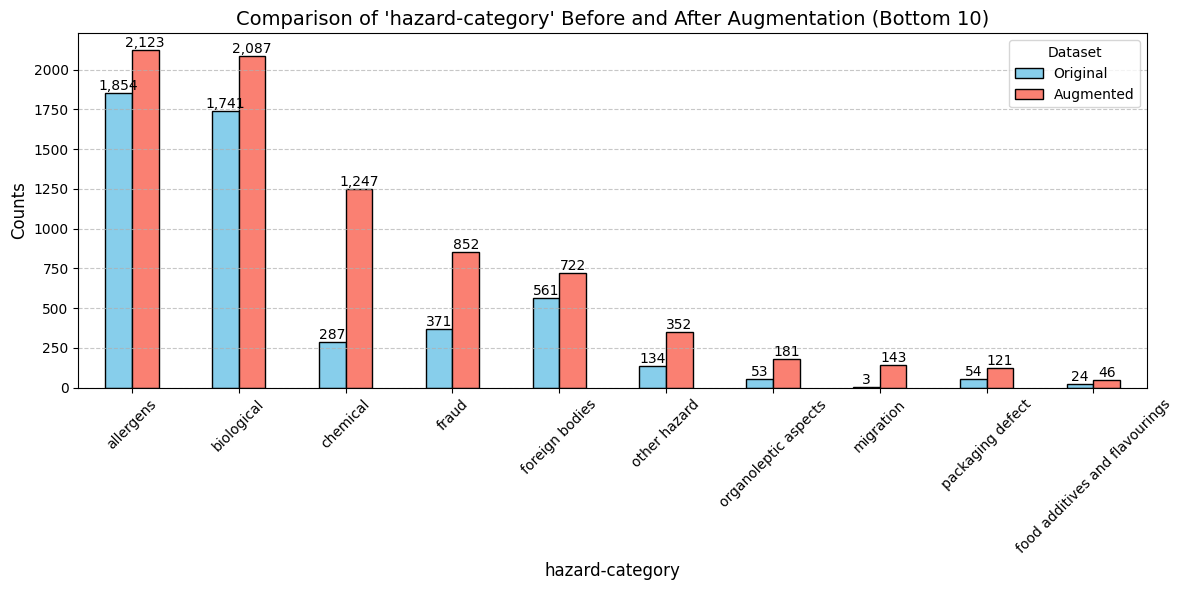


### Column: product-category ###
                                Original  Augmented
product-category                                   
herbs and spices                     125        196
alcoholic beverages                   59        166
food contact materials                 7        164
other food product / mixed            55        117
fats and oils                         19        109
pet feed                              20         91
sugars and syrups                      5         87
honey and royal jelly                  8         58
feed materials                         6         46
food additives and flavourings         8         41


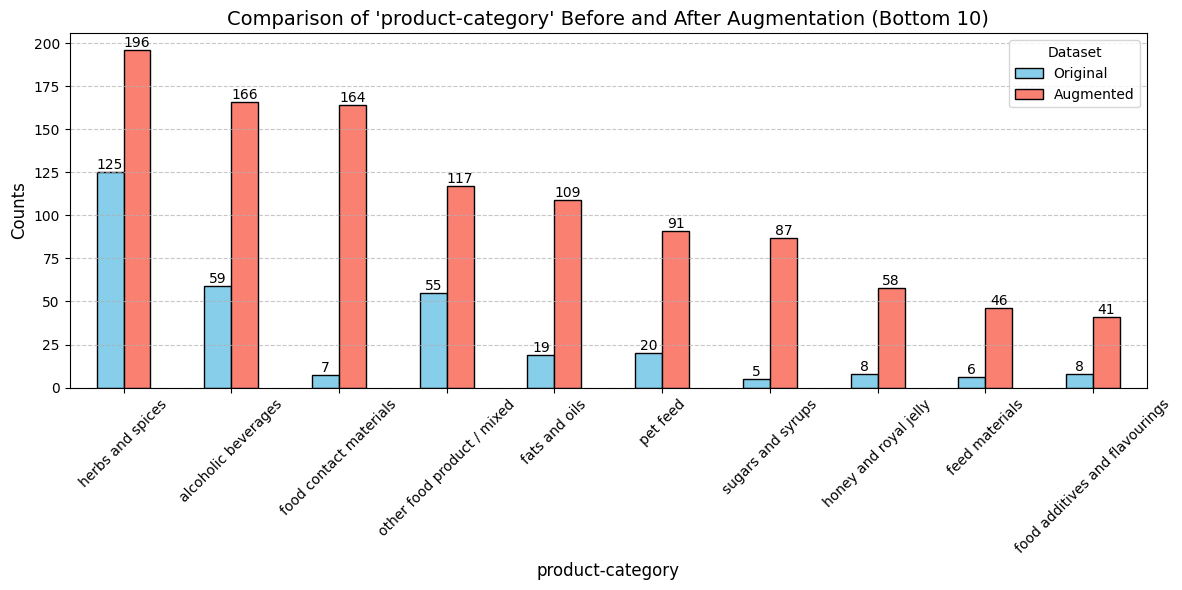


### Column: hazard ###
                                  Original  Augmented
hazard                                               
bone fragment                           12         23
sulphates/sulphites                      9         23
staphylococcus                           9         23
improper conditions                     13         23
high content of cyanide                  9         23
poor or insufficient controls           12         23
enteroviruses                           10         23
specified risk material (srm)            9         23
chemical compound (unauthorised)        11         23
cyclospora                              10         23


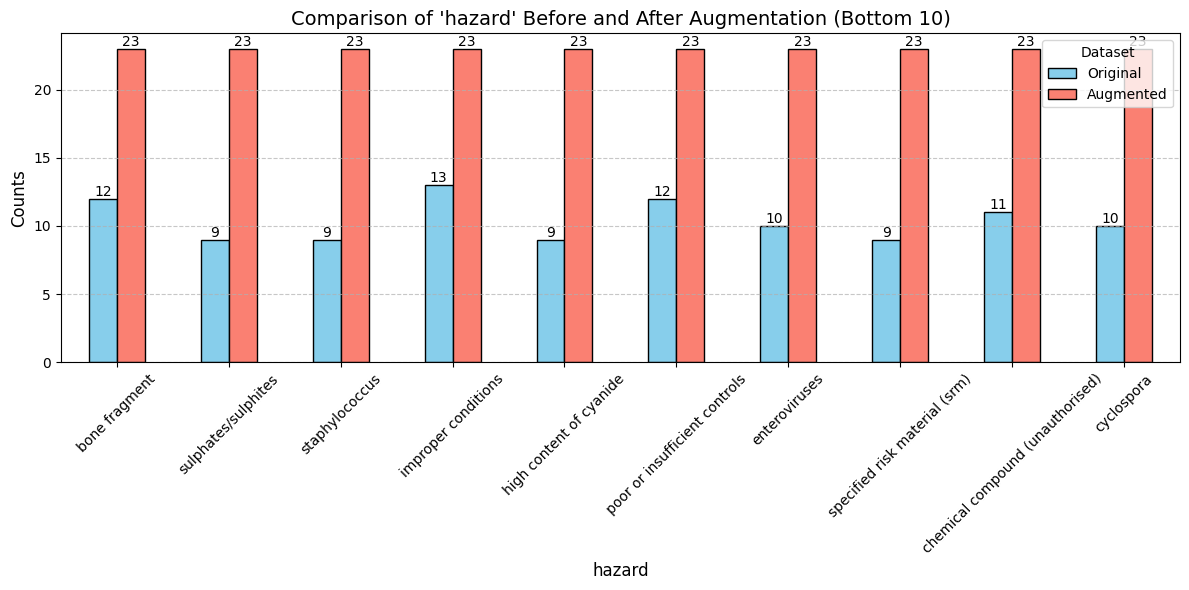


### Column: product ###
                                          Original  Augmented
product                                                      
plums                                            1          1
plum bread &amp; butter pudding                  1          1
filled chocolate                                 1          1
fish sauce                                       1          1
flavoured drinks                                 1          1
pine nuts                                        1          1
flavoured fresh and creamy cheese spread         1          1
pickled radish                                   1          1
flavoured soft drink                             1          1
ham slices                                       1          1


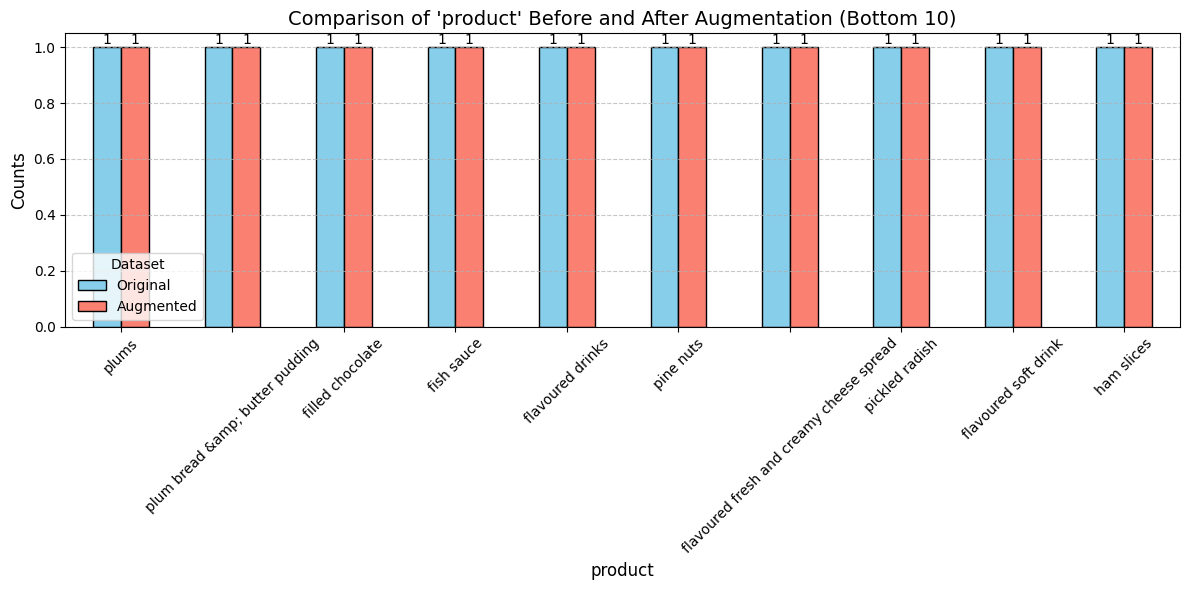

In [177]:
columns_to_compare = ['hazard-category', 'product-category', 'hazard', 'product']
compare_augmentation_effects(data, balanced_3, columns_to_compare, show_top=False)

### Compare Effect of Data Augmentation for 10 High Classes for the DataFrame `balanced_3`


### Column: hazard-category ###
                                Original  Augmented
hazard-category                                    
allergens                           1854       2123
biological                          1741       2087
chemical                             287       1247
fraud                                371        852
foreign bodies                       561        722
other hazard                         134        352
organoleptic aspects                  53        181
migration                              3        143
packaging defect                      54        121
food additives and flavourings        24         46


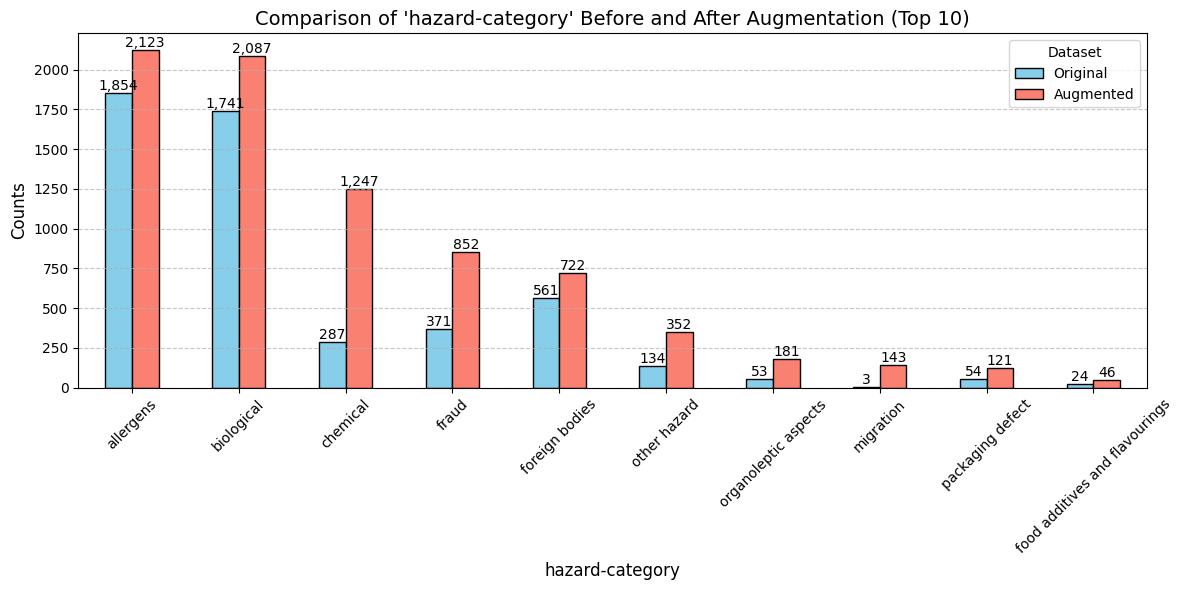


### Column: product-category ###
                                              Original  Augmented
product-category                                                 
meat, egg and dairy products                      1434       2064
cereals and bakery products                        671        842
fruits and vegetables                              535        728
prepared dishes and snacks                         469        547
seafood                                            268        485
nuts, nut products and seeds                       262        357
cocoa and cocoa preparations, coffee and tea       210        347
soups, broths, sauces and condiments               264        347
confectionery                                      170        284
ices and desserts                                  222        272


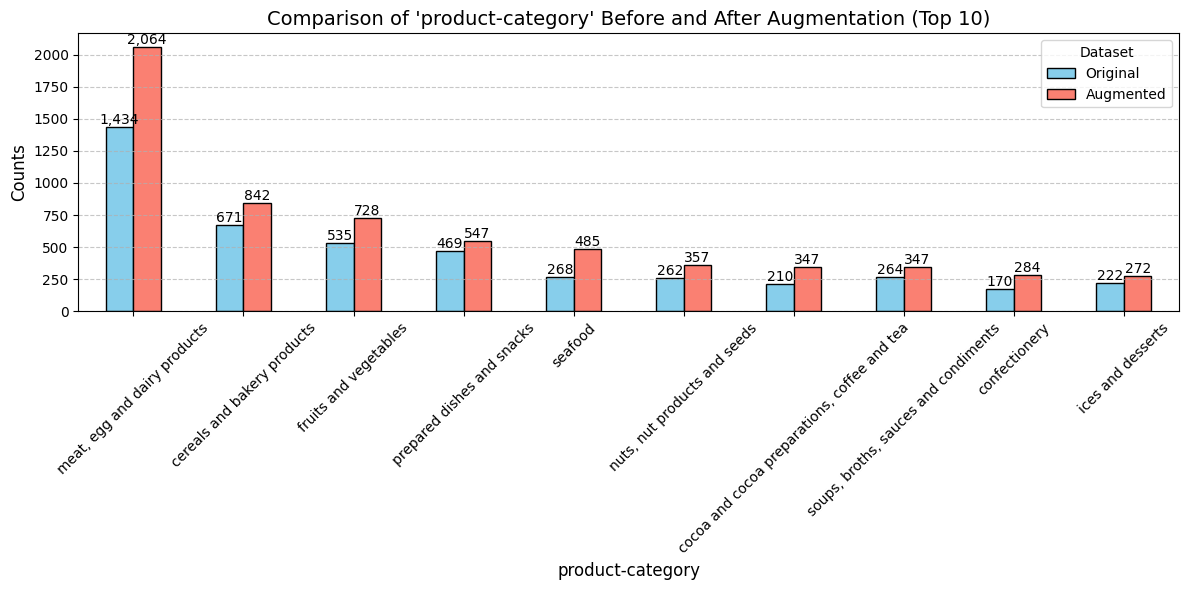


### Column: hazard ###
                                                Original  Augmented
hazard                                                             
listeria monocytogenes                               665        666
salmonella                                           621        623
milk and products thereof                            588        592
other                                                102        247
escherichia coli                                     237        237
plastic fragment                                     206        235
cereals containing gluten and products thereof       207        223
peanuts and products thereof                         211        212
eggs and products thereof                            208        209
metal fragment                                       155        193


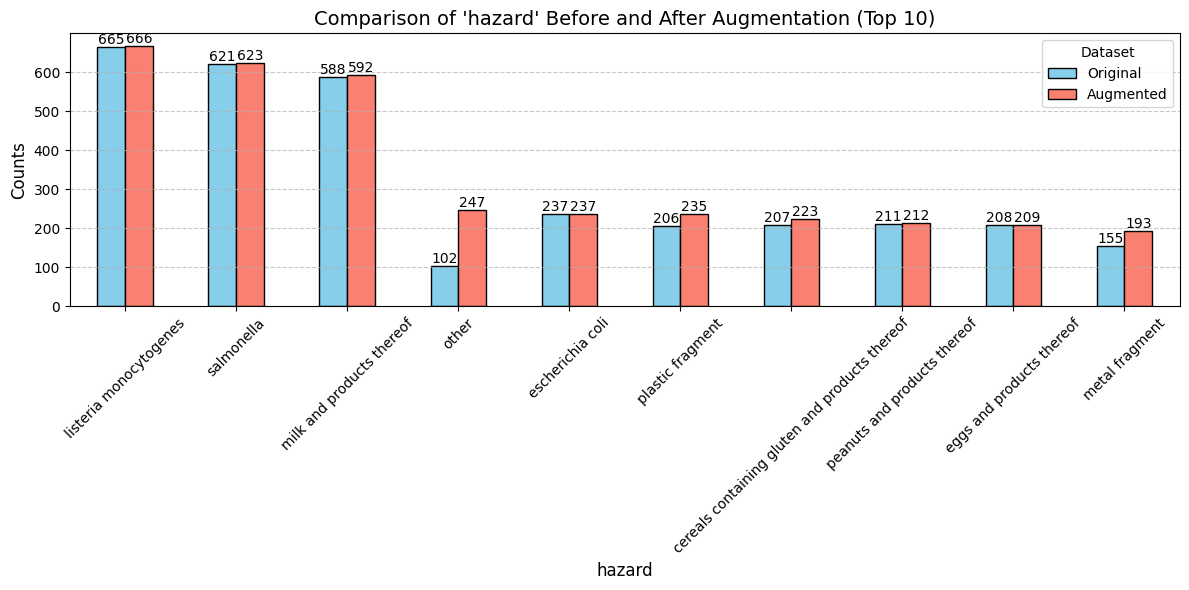


### Column: product ###
                           Original  Augmented
product                                       
ice cream                       185        226
chicken based products          138        199
plastics                          6        162
cakes                            93        110
ready to eat - cook meals        79         98
cookies                          78         91
pet feed                         20         91
beer                             25         80
cheese                           74         74
eggs                             26         72


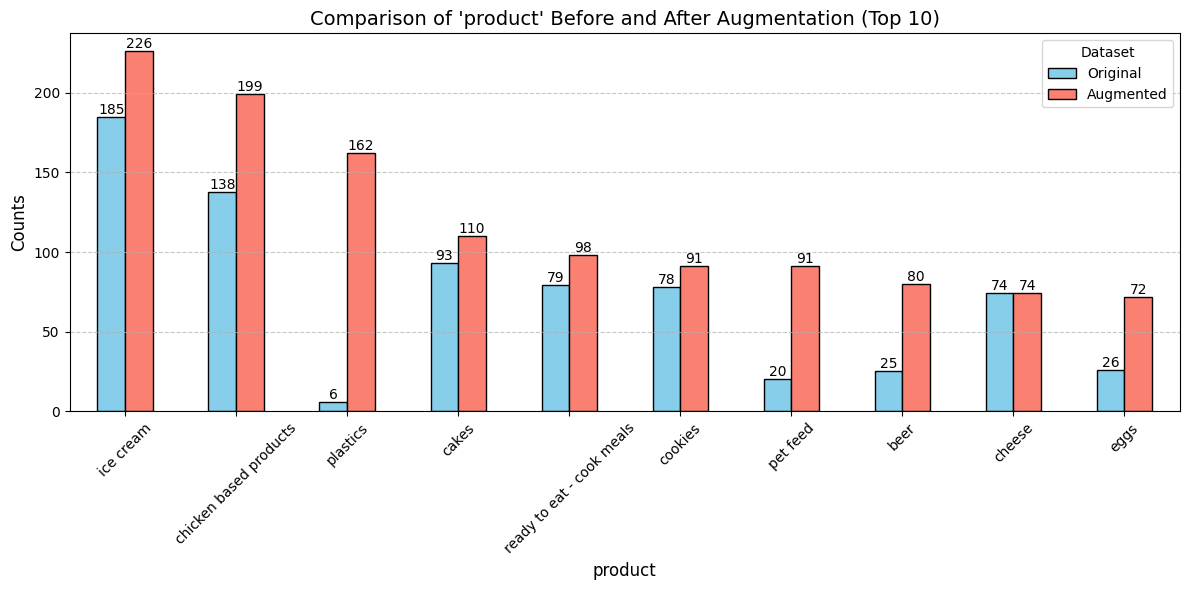

In [178]:
columns_to_compare = ['hazard-category', 'product-category', 'hazard', 'product']
compare_augmentation_effects(data, balanced_3, columns_to_compare, show_top=True)

- Now, we will save the data-augmented datafarme to `csv` named `data_augmented_incidents_train.csv` only for the datafarme `balanced_4` as `balanced_3` in some classes has only 1 data. This is problimatic (many problems liek breaks SMOTE code next due to neigthbours boud).

In [179]:
# balanced_4.to_csv("data_augmented_incidents_train.csv", index=False) # save data augmented data.

In [180]:
balanced_4

,year,month,day,country,title,text,hazard-category,product-category,hazard,product
0,1994,1,7,us,Recall Notification: FSIS-024-94,Case Number: 024-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,smoked sausage
1,1994,3,10,us,Recall Notification: FSIS-033-94,Case Number: 033-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria spp,sausage
2,1994,3,28,us,Recall Notification: FSIS-014-94,Case Number: 014-94 \n Date Opene...,biological,"meat, egg and dairy products",listeria monocytogenes,ham slices
3,1994,4,3,us,Recall Notification: FSIS-009-94,Case Number: 009-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,thermal processed pork meat
4,1994,7,1,us,Recall Notification: FSIS-001-94,Case Number: 001-94 \n Date Opene...,foreign bodies,"meat, egg and dairy products",plastic fragment,chicken breast
...,...,...,...,...,...,...,...,...,...,...
13545,2022,7,19,hk,fibrocystic_disease_of_the_pancreas urge_on pu...,CF exhort populace not to devour sort of cup a...,chemical,other food product / mixed,unauthorised substance ethylene oxide,ramen noodles
13546,2022,7,19,hk,pancreatic_fibrosis cheer public not to go_thr...,Cf inspire populace not to deplete sort of cup...,chemical,other food product / mixed,unauthorised substance ethylene oxide,ramen noodles
13547,2022,7,19,hk,CF advocate public to go_through sort of cup b...,Cf inspire public not to go_through variety of...,chemical,other food product / mixed,unauthorised substance ethylene oxide,ramen noodles
13548,2022,7,19,hk,CF barrack world non to waste genial of cup no...,mucoviscidosis impulse populace not to exhaust...,chemical,other food product / mixed,unauthorised substance ethylene oxide,ramen noodles


Column "product-category" (n = 22):

  meat, egg and dairy products:                       3591
  fruits and vegetables:                              1656
  cereals and bakery products:                        1253
  prepared dishes and snacks:                         1043
  seafood:                                             794
  alcoholic beverages:                                 727
  soups, broths, sauces and condiments:                667
  nuts, nut products and seeds:                        620
  herbs and spices:                                    565
  non-alcoholic beverages:                             531
  cocoa and cocoa preparations, coffee and tea:        519
  dietetic foods, food supplements, fortified foods:   464
  confectionery:                                       450
  ices and desserts:                                   309
  other food product / mixed:                          238
  food contact materials:                              169
  fats and oils:   

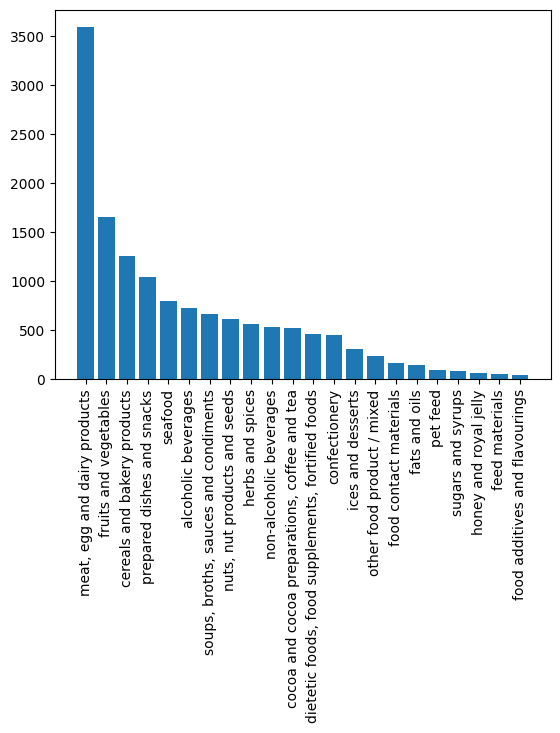

In [181]:
print_column(balanced_4, 'product-category',22)

Column "product" (n = 1022):

  chicken:                                             731
  cheese:                                              690
  beef:                                                535
  chocolate:                                           507
  milk:                                                352
  sauce:                                               294
  sausage:                                             282
  nuts:                                                279
  ice cream:                                           226
  rice:                                                212
  chicken based products:                              199
  pork meat:                                           186
  beef meat:                                           181
  plastics:                                            162
  cakes:                                               143
  bars:                                                138
  cereal:                 

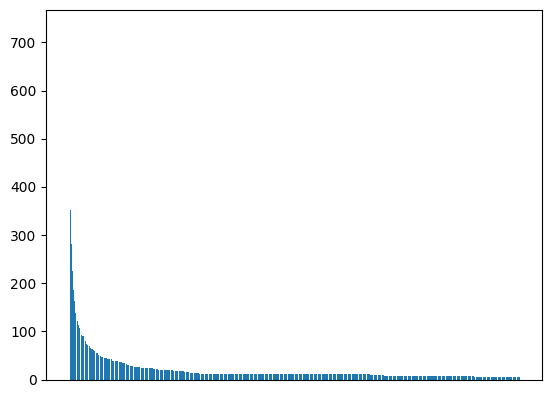

In [182]:
print_column(balanced_4, 'product',1500)

Column "hazard" (n = 128):

  listeria monocytogenes:                             1324
  salmonella:                                         1306
  milk and products thereof:                          1247
  other:                                               756
  cereals:                                             550
  cereals containing gluten and products thereof:      516
  nuts:                                                513
  peanuts and products thereof:                        466
  escherichia coli:                                    442
  eggs and products thereof:                           432
  plastic fragment:                                    403
  sulphur dioxide:                                     385
  soybeans and products thereof:                       340
  metal fragment:                                      327
  inspection issues:                                   321
  sulphur dioxide and sulphites:                       297
  toxin:                    

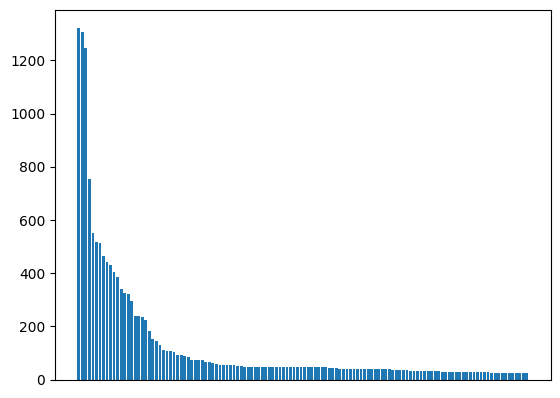

In [183]:
print_column(balanced_4, 'hazard',128)

Column "hazard" (n = 128):

  listeria monocytogenes:                             1324
  salmonella:                                         1306
  milk and products thereof:                          1247
  other:                                               756
  cereals:                                             550
  cereals containing gluten and products thereof:      516
  nuts:                                                513
  peanuts and products thereof:                        466
  escherichia coli:                                    442
  eggs and products thereof:                           432


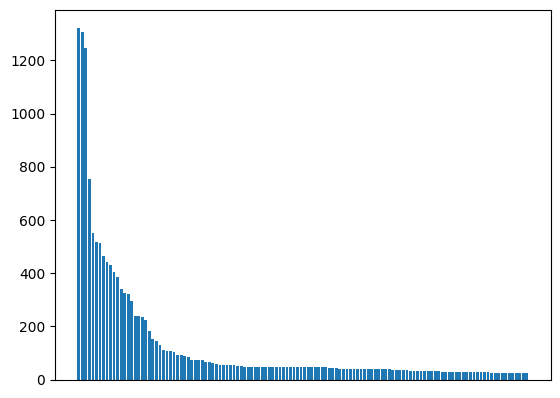

In [184]:
print_column(balanced_4, 'hazard')

In [185]:
# duplicate 
balanced_4[balanced_4['text'].duplicated()].shape[0] # TODO
balanced_4[balanced_4['text'].duplicated()]

,year,month,day,country,title,text,hazard-category,product-category,hazard,product
573,2011,9,21,ca,Certain Gatorade brand products are being reca...,Notice This archive of previously issued food ...,organoleptic aspects,non-alcoholic beverages,spoilage,sport drink
603,2012,1,27,ca,Pinnacle Foods Group LLC Issues Allergy Alert ...,Notice This archive of previously issued food ...,allergens,cereals and bakery products,soybeans and products thereof,pancakes
691,2012,8,8,ca,Various milk may contain extraneous material,Various milk may contain extraneous material R...,foreign bodies,"meat, egg and dairy products",foreign bodies,milk
709,2012,9,25,ca,Certain TRADER JOE'S brand NUT BUTTERS may con...,Notice This archive of previously issued food ...,biological,"nuts, nut products and seeds",salmonella,walnuts
714,2012,9,27,ca,Various beef products may contain E. coli O157...,Notice This archive of previously issued food ...,biological,"meat, egg and dairy products",escherichia coli,beef products
717,2012,10,1,ca,Certain Nestle brand Chocolate Peanut Butter I...,Notice This archive of previously issued food ...,biological,ices and desserts,salmonella,ice cream
1073,2014,9,12,uk,"Spiceway, Rutherglen products handled and pack...","GSR Distributions Ltd, trading as Spiceway, Ru...",fraud,"meat, egg and dairy products",unauthorised placing on the market,chilled chicken parts
1107,2014,10,16,uk,Jumbo UK Ltd recalls its Nigeria Taste Brown B...,Risk\nJumbo UK Ltd has recalled all batches of...,chemical,fruits and vegetables,chemical compound (high content),brown beans
1145,2014,12,23,uk,Ades Limited products handled and packaged in ...,"Ades Limited, 1 Eastmoor Street, Charlton, Lon...",fraud,seafood,other,seafood products
1150,2014,12,27,us,Texas Firm Recalls Pork Products Due To Misbra...,"WASHINGTON, December 27, 2014 – Garcia Foods, ...",allergens,"meat, egg and dairy products",peanuts and products thereof,chorizo


In [186]:
balanced_4[balanced_4['title'].duplicated()].shape[0] # TODO

198

In [199]:
balanced_4[balanced_4['text'].duplicated()].shape[0] # TODO

29